# Foraging Theory
To test and apply the results from "Normative theory of foraging".

## Initial setup

In [42]:
# Numerical tools
import numpy as np
import scipy
from scipy.special import factorial
from scipy.optimize import brentq, newton
import math

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# General utils
import time
from datetime import timedelta

# Custom modules
import sys
sys.path.insert(0, '../python/')
import ephys
import util

## Piecewise-homogeneous Poisson process

### Parameter estimation
The paper approximates the encounters with reward in a patch as a *piecewise homogeneous Poisson process*. Intuitively, the authors hint at a scenario in which discrete units of reward are dispersed randomly within a given area (patch). For this initial distribution of rewards, a random walk by the animal in the patch would yield encounter times that follow a Poisson distribution with rate $\lambda_0$. If the patch continued to be sampled *without* replacement, then the process would simply continue with rate $\lambda_0$ until the animal left the patch; however, because rewards are consumed upon encounter, the Poisson rate declines proportionally to the amount of rewards consumed. In other words, the Poisson rate of reward encounters for a random walk through a patch depends on the density of rewards available. Here, the rate is modeled as decreasing linearly with reward consumption:

$
\quad \lambda(t) = \lambda_0 - \rho K(t)
$

where $K(t)$ is the number of rewards consumed at time $t$, and $\rho$ is a model parameter that governs the discretized Poisson rate decay.

Let's say the animal encounters rewards at specific times $t_k$ that generate a sequence $x(t) = K'(t) = \sum_{j=1}^{K(t)} \delta (t - t_j)$, where, due to the Poisson process, the encounter times follow an exponential distribution: $t_k \sim (\lambda_0 - \rho k) e^{-(\lambda_0 - \rho k)}$. What is the likelihood of the Poisson rate $\lambda$ given these observations?

$
\begin{align}
\quad p(\lambda | x(t)) 
&= p(x(t) | \lambda) \dfrac{p_0(\lambda + K(t) \rho)}{p(x(t))} \\
&\propto p(x(t) | \lambda) p_0(\lambda_0)
\end{align}
$

$
\begin{align}
\quad p(x(t) | \lambda)
&= \prod_{k=1}^{K} \lambda_k e^{-\lambda_k t_k} \\
&= \prod_{k=1}^{K} \left ( \lambda + \rho (K - k) \right ) e^{- \left ( \lambda + \rho (K - k) \right ) t_k} \\
&= \prod_{k=1}^{K} \rho \left ( \frac{\lambda}{\rho} + K - k \right ) e^{- \left ( \lambda + \rho (K - k) \right ) t_k} \\
&= \rho^K \prod_{k=1}^{K} \left ( \frac{\lambda}{\rho} + K - k \right ) e^{- \left ( \lambda + \rho (K - k) \right ) t_k} \\
&= \rho^K \dfrac{\left ( \frac{\lambda}{\rho} + K \right )!}{\frac{\lambda}{\rho} !} \prod_{k=1}^{K} e^{- \left ( \lambda + \rho (K - k) \right ) t_k} \\
&= \rho^K \dfrac{\left ( \frac{\lambda}{\rho} + K \right )!}{\frac{\lambda}{\rho} !} e^{- \sum_{k=1}^{K} \left ( \lambda + \rho (K - k) \right ) t_k} \\
&= \rho^K \dfrac{\left ( \frac{\lambda}{\rho} + K \right )!}{\frac{\lambda}{\rho} !} e^{- \sum_{k=1}^{K} \left ( \lambda t_k + \rho (K - k) t_k \right )} \\
&= \rho^K \dfrac{\left ( \frac{\lambda}{\rho} + K \right )!}{\frac{\lambda}{\rho} !} e^{- \sum_{k=1}^{K} \lambda t_k - \sum_{k=1}^{K} \rho (K - k) t_k} \\
&= \rho^K \dfrac{\left ( \frac{\lambda}{\rho} + K \right )!}{\frac{\lambda}{\rho} !} e^{-\lambda \sum_{k=1}^{K} t_k} e^{-\sum_{k=1}^{K} \rho (K - k) t_k} \\
&= \rho^K \dfrac{\left ( \frac{\lambda}{\rho} + K \right )!}{\frac{\lambda}{\rho} !} e^{-\lambda t} f(t_0, \ldots, t_k) \\
&\propto \dfrac{\left ( \frac{\lambda}{\rho} + K \right )!}{\frac{\lambda}{\rho} !} e^{-\lambda t}
\end{align}
$

where we can drop the $\rho^K$ and $f(\cdot)$ because we are only interested in how our likelihood depends on our estimate for $\lambda$. Therefore, the likelihood becomes:

$
\quad p(\lambda | x(t)) \propto \dfrac{\left ( \frac{\lambda}{\rho} + K \right )!}{\left ( \frac{\lambda}{\rho}  \right )!} e^{-\lambda t} p_0(\lambda_0)
$

### Non-depletion limit
As the model parameter $\rho$ approaches zero, the process becomes homogeneous, leading to:

$
\begin{align}
\quad \lim_{\rho \rightarrow 0^+} p(\lambda | x(t))
&= \lim_{\rho \rightarrow 0^+} p(x(t) | \lambda) \dfrac{p(\lambda_0)}{p(x(t))} \\
&= \dfrac{p(\lambda_0)}{p(x(t))} \lim_{\rho \rightarrow 0^+} \prod_{k=1}^{K} \left ( \lambda + \rho (K - k) \right ) e^{- \left ( \lambda + \rho (K - k) \right ) t_k} \\
&= \dfrac{p(\lambda_0)}{p(x(t))} \prod_{k=1}^{K} \lambda e^{-\lambda t_k} \\
&= \dfrac{p(\lambda_0)}{p(x(t))} \lambda^K e^{-\lambda \sum_{k=1}^{K} t_k} \\
&= \dfrac{p(\lambda_0)}{p(x(t))} \lambda^K e^{-\lambda t}
\end{align}
$

### Continuous limit
How do we relate the piecewise homogeneous process above to a continuous non-homogeneous Poisson process (both of which are depleting over time)? Let's begin by calculating our expected reward encounter times $t_k$ for the above process by defining each $t_k$ to be the $k$th interevent interval and $T(k)$ to be the total time at the $k$th event (a bit different from above, which I will need to correct later for clarity):

$
\quad \mathbb{E}[T(k)] 
= \sum_k \mathbb{E[t_k]} 
= \sum_k \frac{1}{\lambda_k} 
= \sum_k \frac{1}{\lambda_0 - \rho k}
$

where we compute the expected interevent interval for encounter $k$ as the Poisson mean. Summing over this series of Poisson means, we arrive at:

$
\begin{align}
\quad \sum_k \frac{1}{\lambda_0 - \rho k}
&= \frac{1}{\rho} \sum_k \frac{1}{\frac{\lambda_0}{\rho} - k} \\
&= \frac{1}{\rho} \left ( \frac{1}{m_0} + \frac{1}{m_0 - 1} + \cdots + \frac{1}{m_0 - k} \right ) \\
&= \frac{1}{\rho} \left ( \frac{1}{m_0} + \cdots + 1 \right ) - \frac{1}{\rho} \left ( \frac{1}{m_0 - k - 1} + \cdots + 1 \right ) \\
&= \frac{1}{\rho} H_{m_0} - \frac{1}{\rho} H_{m_0 - k} \\
&= \frac{1}{\rho} \left ( H_{m_0} - H_{m_0 - k} \right )
\end{align}
$

where $m_0 = \frac{\lambda_0}{\rho}$ and $H_n$ is the $n$th harmonic number. Using the Euler–Mascheroni constant $\gamma$, we can approximate this equation:

$
\begin{align}
\quad \frac{1}{\rho} \left ( H_{m_0} - H_{m_0 - k} \right )
&= \frac{1}{\rho} \left ( \left ( \gamma + ln(m_0) + O \left ( \frac{1}{m_0} \right ) \right ) - \left ( \gamma - ln(m_0 - k) + O \left ( \frac{1}{m_0 - k} \right ) \right ) \right ) \\
&= \frac{1}{\rho} \left ( ln(m_0) - ln(m_0 - k) + O \left ( \frac{1}{m_0} - \frac{1}{m_0 - k} \right ) \right )
\end{align}
$

We can set the approximation error term $\epsilon = O \left ( \frac{1}{m_0} - \frac{1}{m_0 - k} \right )$ and solve for $T(k)$:

$
\begin{align}
\quad T(k) = \frac{1}{\rho} \left ( ln(m_0) - ln(m_0 - k) + \epsilon \right ) \\
\quad \Rightarrow \rho T - \epsilon = ln \left ( \dfrac{m_0}{m_0 - k} \right ) \\
\quad \Rightarrow k = m_0 \left ( 1 - e^{-\rho T + \epsilon} \right )
\end{align}
$

Note that the error term $\epsilon$ depends on $k$, meaning that there is no simple solution to the above equation. However, we can observe that in the limit that $\rho$ becomes zero:

$
\begin{align}
\quad \lim_{\rho \rightarrow 0} \epsilon
&= \lim_{\rho \rightarrow 0} O \left ( \frac{1}{m_0} - \frac{1}{m_0 - k} \right ) \\
&= \lim_{\rho \rightarrow 0} O \left ( \frac{1}{\frac{\lambda_0}{\rho}} - \frac{1}{\frac{\lambda_0}{\rho} - k} \right ) \\
&= \lim_{\rho \rightarrow 0} O \left ( \frac{\rho}{\lambda_0} - \frac{\rho}{\lambda_0 - \rho k} \right ) \\
&= \lim_{\rho \rightarrow 0} O \left ( \rho \left ( \frac{1}{\lambda_0} - \frac{1}{\lambda_0 - \rho k} \right ) \right ) \\
&= 0
\end{align}
$

$
\begin{align}
\quad &\Rightarrow \lim_{\rho \rightarrow 0} \epsilon = 0 \; \forall \; k \text{ such that } 0 \leq k < \frac{\lambda_0}{\rho} \\
&\Rightarrow \lim_{\rho \rightarrow 0} k(T) = m_0 \left ( 1 - e^{-\rho T} \right )
\end{align}
$

Plugging $k(T)$ into our equation for $\lambda(T)$:

$
\begin{align}
\quad \lambda(T)
&= \lambda_0 - \rho k(T) \\
&= \lambda_0 - \rho \left ( m_0 \left ( 1 - e^{-\rho T} \right ) \right ) \\
&= \lambda_0 - \rho \frac{\lambda_0}{\rho} \left ( 1 - e^{-\rho T} \right ) \\
&= \lambda_0 - \lambda_0 \left ( 1 - e^{-\rho T} \right ) \\
&= \lambda_0 e^{-\rho T}
\end{align}
$

Therefore, as the model parameter $\rho$ becomes very small, the piecewise homogeneous Poisson process approaches a non-homogeneous Poisson process with an exponentially decaying rate parameter.

### Maximum likelihood estimation of $\lambda$
Here, we will visualize how the likelihood estimate for the Poisson rate evolves over time as the animal encounters rewards, based on our calculated probabilities above.

In [137]:
# Set initial parameters
lam_0 = 1.0
rho = 0.05

# Simulate piecewise-homogeneous Poisson process
K = int(lam_0/rho)
lam = lam_0
T = []
while not np.isclose(lam, 0.0):
    t_k = ephys.Poisson(lam=lam).times(interevent=True, n=1)
    T.append(t_k)
    lam -= rho

# Check data
T = np.cumsum(np.array(T))
assert T.shape[0] == K

In [138]:
# Estimate lambda
lam_range = np.linspace(0.0, 1.0, num=100)
T_range = np.linspace(0.0, T.max(), num=100)
k_T = np.sum(T_range[:, np.newaxis] >= T[np.newaxis, :], axis=1)
p = factorial(lam_range[:, np.newaxis]/rho + k_T[np.newaxis, :])/factorial(lam_range[:, np.newaxis]/rho) \
    * np.exp(-lam_range[:, np.newaxis]*T_range[np.newaxis, :])
p /= np.max(p, axis=0) # normalize for given time bin

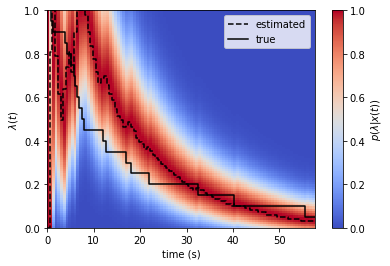

In [141]:
fig, ax = plt.subplots()

# Plot likelihood estimates
cmap = plt.get_cmap('coolwarm')
im = ax.pcolormesh(T_range,
                   lam_range,
                   p,
                   cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('$p(\lambda | x(t))$')

# Plot MLE
ax.step(T_range,
        lam_range[np.argmax(p, axis=0)],
        color='black',
        linestyle='--',
        label='estimated')

# Plot true parameter
ax.step(T, lam_0 - np.arange(K)*rho, 
        where='pre',
        color='black',
        label='true')

# Set labels
ax.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('$\lambda(t)$');

## Non-homogeneous Poisson process
Let's now take a look at how closely a non-homogeneous Poisson process can approximate this piecewise homogeneous Poisson process.

### Reward characteristics

#### Single trial simulation

In [72]:
# Set initial parameters
lam_0 = 1.0
rho = 0.05

# Simulate piecewise-homogeneous Poisson process
K = int(lam_0/rho)
lam = lam_0
T_k = []
while lam > 0.0:
    t_k = ephys.Poisson(lam=lam).times(interevent=True, n=1)
    T_k.append(t_k)
    lam -= rho

# Check data
T_k = np.cumsum(np.array(T_k))
assert T_k.shape[0] == K

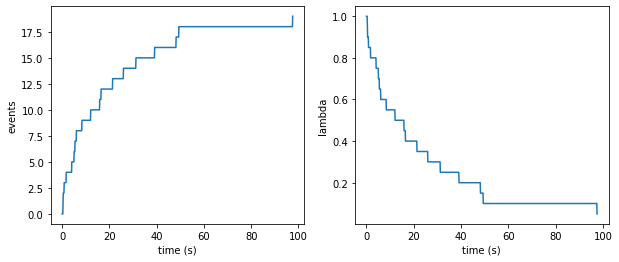

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Compute number of events K as function of t
t = np.linspace(0.0, T_k.max(), 1000)
K_t = np.zeros(t.shape)
K_t[np.searchsorted(t, T_k, side='left')] = 1
K_t = np.cumsum(K_t)

# Plot K vs. t
ax[0].plot(t, K_t)
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('events')

# Compute lambda as function of t
lam_t = lam_0*np.ones(t.shape) - rho*K_t

# Plot lambda vs. t
ax[1].plot(t, lam_t)
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('lambda');

#### Batch simulation
Let's now average the statistics over many trials to approximate the limit of a continuous distribution.

In [74]:
# Set initial parameters
lam_0 = 1.0
rho = 0.01

# Simulate process
N = 10000 # number of trials
K = int(lam_0/rho) # max number of events
t_k = np.empty([N, K])
for i in range(K):
    lam = lam_0 - rho*i
    t_k[:, i] = ephys.Poisson(lam=lam).times(interevent=True, n=N)

T_k = np.cumsum(t_k, axis=1) # cumulative event times

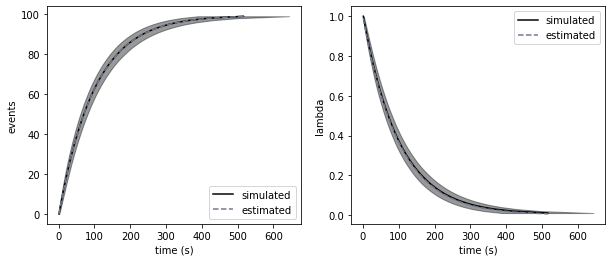

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
cmap = plt.get_cmap('bone')

# Plot K vs. t
ax[0].plot(np.mean(T_k, axis=0), 
           np.arange(K),
           color=cmap(0.0),
           label='simulated')
ax[0].fill_betweenx(np.arange(K),
                    x1=np.mean(T_k, axis=0)-np.std(T_k, axis=0),
                    x2=np.mean(T_k, axis=0)+np.std(T_k, axis=0),
                    color=cmap(0.0),
                    alpha=0.4)
ax[0].plot(np.cumsum(1.0/(lam_0 - rho*np.arange(K))), 
           np.arange(K),
           color=cmap(0.5),
           linestyle='--',
           label='estimated')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('events')
ax[0].legend()

# Plot lambda vs. t
ax[1].plot(np.mean(T_k, axis=0), 
           lam_0 - rho*np.arange(K),
           color=cmap(0.0),
           label='simulated')
ax[1].fill_betweenx(lam_0 - rho*np.arange(K),
                    x1=np.mean(T_k, axis=0)-np.std(T_k, axis=0),
                    x2=np.mean(T_k, axis=0)+np.std(T_k, axis=0),
                    color=cmap(0.0),
                    alpha=0.4)
ax[1].plot(np.mean(T_k, axis=0), 
           lam_0*np.exp(-rho*np.mean(T_k, axis=0)),
           color=cmap(0.5),
           linestyle='--',
           label='estimated')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('lambda')
ax[1].legend();

Note that as $\rho \rightarrow 0$, the estimated $\lambda(t)$ becomes a better approximation.

#### Reward dependency on time

In [408]:
# Settings
lam_0 = 1.0 # initial drip parameter
tau = 12.0 # rate of decay of lambda
r_drip = 2.0

# Poisson parameter functions for drip process
lam = lambda t: lam_0*np.exp(-t/tau) # lambda(t)
Lam = lambda t, s: lam_0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau)) # integral

# Create model
model = ephys.Poisson(lam=lam, Lam=Lam, homogeneous=False)

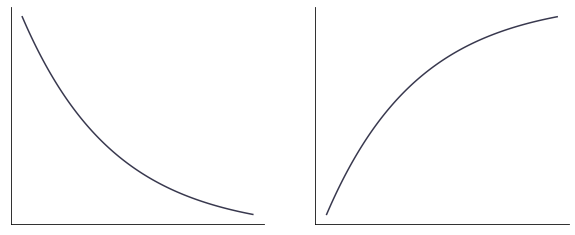

In [403]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
cmap = plt.get_cmap('bone')

# Plot deterministic rewards
tt = np.linspace(0.0, 30.0, num=100)
ax[0].plot(tt, 
           r_drip*lam_0*np.exp(-tt/tau),
           color=cmap(0.25),
           linestyle='-',
           label='deterministic')
ax[1].plot(tt, 
           r_drip*lam_0*tau*(1.0 - np.exp(-tt/tau)),
           color=cmap(0.25),
           linestyle='-',
           label='deterministic')

# Clean up plots
for ax_ in ax:
    ax_.set_xticks([])
    ax_.set_yticks([])
    ax_.spines['right'].set_visible(False)
    ax_.spines['top'].set_visible(False)
    
plt.savefig('/home/james/Desktop/patch_deterministic.pdf')

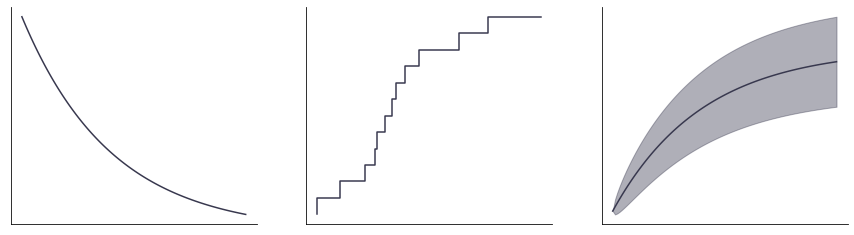

In [409]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
cmap = plt.get_cmap('bone')

# Simulate single patch
T_k = model.times(interevent=False, s=30.0)
K = len(T_k)

# Plot Poisson rewards
ax[0].plot(tt, 
           r_drip*model.lam(tt),
           color=cmap(0.25),
           linestyle='-',
           label='Poisson')
ax[1].step(T_k, 
           r_drip*np.arange(K), 
           where='pre',
           color=cmap(0.25),
           label='Poisson')
ax[2].plot(tt,
           r_drip*model.Lam(0, tt),
           color=cmap(0.25),
           linestyle='-',
           label='Poisson')
ax[2].fill_between(tt,
                   y1=r_drip*model.Lam(0, tt)-(r_drip**2*model.Lam(0, tt))**0.5,
                   y2=r_drip*model.Lam(0, tt)+(r_drip**2*model.Lam(0, tt))**0.5,
                   color=cmap(0.25),
                   alpha=0.4)

# Clean up plots
for ax_ in ax:
    ax_.set_xticks([])
    ax_.set_yticks([])
    ax_.spines['right'].set_visible(False)
    ax_.spines['top'].set_visible(False)
    
plt.savefig('/home/james/Desktop/patch_Poisson_high_variance.pdf')

### Single sequence parameter estimation
Here, we will jointly estimate the two parameters of our non-homogeneous Poisson process above: the initial rate $\lambda_0$ (or current rate $\lambda$) and decay rate $\tau$.

#### Maximum likelihood estimation of parameters

We will begin with one-shot learning of the Poisson parameters ($\lambda$ and $\tau$) given a sequence of rewards at times $t_k$ for a non-homogeneous Poisson process characterized by:

$
\quad \lambda(t) 
= \lambda_0 e^{\frac{-t}{\tau}} \\
\quad \Lambda(t) 
= \int_{0}^{t} \lambda_0 e^{\frac{-t'}{\tau}} dt' 
= \lambda_0 \tau \left ( 1 - e^{\frac{-t}{\tau}} \right )
$

Now we want to maximize the probability of a Poisson rate $\lambda$ given the sequence of reward times $x(t)$ with respect to its parameters: the initial rate $\lambda_0$ and decay rate $\tau$ (which is the inverse of the parameter $\rho$ in the piecewise process analysis above). This probability is given by:

$
\quad p(\lambda | x(t); \lambda_0, \tau)
= e^{-\Lambda(t)} \dfrac{\left ( \Lambda(t) \right )^K}{K!} \\
\quad ln(p(\lambda | x(t); \lambda_0, \tau))
= -\Lambda(t) + K ln \left ( \Lambda(t) \right ) - ln(K!)
$

where the probability is simply $Poisson(\Lambda(t))$ as for any non-homogeneous Poisson process. Taking the derivative with respect to either of the parameters and setting it equal to zero, we arrive at:

$
\quad \dfrac{\mathrm{d} ln(p(\lambda | x(t); \lambda_0, \tau)}{\mathrm{d} \Lambda}
= -1 + \dfrac{K}{\Lambda(t)}
$

$
\begin{align}
\quad \dfrac{\partial ln(p(\lambda | x(t); \lambda_0, \tau)}{\partial \lambda_0}
&= \dfrac{\partial ln(p(\lambda | x(t); \lambda_0, \tau)}{\partial \Lambda} \dfrac{\partial \Lambda}{\partial \lambda_0} \\
&= \left ( -1 + \dfrac{K}{\Lambda(t)} \right ) \dfrac{\partial}{\partial \lambda_0} \left ( \lambda_0 \tau \left ( 1 - e^{\frac{-t}{\tau}} \right ) \right ) \\
&= \left ( -1 + \dfrac{K}{\lambda_0 \tau \left ( 1 - e^{\frac{-t}{\tau}} \right )} \right ) \dfrac{\partial}{\partial \lambda} \left ( \lambda_0 \tau \left ( 1 - e^{\frac{-t}{\tau}} \right ) \right ) \\
&= \left ( -1 + \dfrac{K}{\lambda_0 \tau \left ( 1 - e^{\frac{-t}{\tau}} \right )} \right ) \left ( \tau \left ( 1 - e^{\frac{-t}{\tau}} \right ) \right ) \\
&= - \tau \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \dfrac{K}{\lambda_0} \\
&= 0 \\
\end{align}
$

$
\quad \Rightarrow \lambda_0 = \dfrac{K}{\tau \left ( 1 - e^{\frac{-t}{\tau}} \right )}
$

$
\begin{align}
\quad \dfrac{\partial ln(p(\lambda | x(t); \lambda_0, \tau)}{\partial \tau}
&= \dfrac{\partial ln(p(\lambda | x(t); \lambda_0, \tau)}{\partial \Lambda} \dfrac{\partial \Lambda}{\partial \tau} \\
&= \left ( -1 + \dfrac{K}{\Lambda(t)} \right ) \dfrac{\partial}{\partial \tau} \left ( \lambda_0 \tau \left ( 1 - e^{\frac{-t}{\tau}} \right ) \right ) \\
&= \left ( -1 + \dfrac{K}{\lambda_0 \tau \left ( 1 - e^{\frac{-t}{\tau}} \right )} \right ) \left ( \lambda_0 \left (1 - e^{-\frac{t}{\tau}} - \dfrac{t}{\tau} e^{-\frac{t}{\tau}} \right ) \right ) \\
&= - \lambda_0 \left (1 - e^{-\frac{t}{\tau}} - \dfrac{t}{\tau} e^{-\frac{t}{\tau}} \right ) + \dfrac{K \left (1 - e^{-\frac{t}{\tau}} - \dfrac{t}{\tau} e^{-\frac{t}{\tau}} \right )}{\tau \left ( 1 - e^{\frac{-t}{\tau}} \right )} \\
&= 0
\end{align}
$

$
\quad \Rightarrow \lambda_0 \left (1 - e^{-\frac{t}{\tau}} - \dfrac{t}{\tau} e^{-\frac{t}{\tau}} \right ) = \dfrac{K \left (1 - e^{-\frac{t}{\tau}} - \dfrac{t}{\tau} e^{-\frac{t}{\tau}} \right )}{\tau \left ( 1 - e^{\frac{-t}{\tau}} \right )}
$

$
\quad \Rightarrow \lambda_0 = \dfrac{K}{\tau \left ( 1 - e^{\frac{-t}{\tau}} \right )}
$

Thus we arrive at the same equation regardless of which parameter with respect to which we maximize the log-likelihood, generating a curve in parameter space that has infinitely many solutions. In fact, this makes sense if we consider how we framed the problem. In the equations above, we related the likelihood only to the total number of events $K$ experienced at time $t$; perhaps a better description of that probability would be $p(\lambda | K, t; \lambda_0, \tau)$. Because we left out all information about when those events occurred--that is, the sequence $x(t)$--any $\Lambda(t; \lambda_0, \tau)$ that equates to $K$ at time $t$ satifies our maximum likelihood estimation. From the lens of the number of events, this finding is the essence of a non-homogeneous Poisson process: its characteristics are those of a homogeneous Poisson process with $\Lambda(t)$ substituted for $\lambda t$. Moreover, our equation for the maximum likelihood scenario demonstrates that it is when the number of events $K$ is equal to the Poisson mean ($\Lambda(t)$):

$
\quad K = \lambda_0 \tau \left ( 1 - e^{\frac{-t}{\tau}} \right ) = \Lambda(t)
$

However, we can incorporate the sequence of events into our MLE to better approximate the most likely parameters. Let's begin by dividing time $t$ into $N$ uniform bins and calculating the probability that the observed $k_n$ events occurred within the $n^{\text{th}}$ bin. The total probability over all $N$ bins is simply a product of the probabilities of the individual bins:

$
\quad p(\lambda | x(t); \lambda_0, \tau) 
= \prod_{n} e^{-\Lambda(t_n)} \dfrac{\left ( \Lambda(t_n) \right)^{k_n}}{k_n!} \\
\quad ln(p(\lambda | x(t); \lambda_0, \tau)) 
= -\sum_{n} \Lambda(t_n) + \sum_n k_n ln(\Lambda(t_n)) - \sum_n ln(k_n!)
= -\Lambda(t) + \sum_n k_n ln(\Lambda(t_n)) - \sum_n ln(k_n!)
$

where $\Lambda(t_n) = \int_{t_{n-1}}^{t_n} \lambda(t') dt'$ and we simplified the summation of $\Lambda(t_n)$ because $\int_{a}^{b} f(x)dx + \int_{b}^{c} f(x)dx = \int_{a}^{c} f(x)dx$. First, we take the derivative with respect to $\lambda_0$ as before:

$
\begin{align}
\quad \dfrac{\partial ln(p(\lambda | x(t); \lambda_0, \tau))}{\partial \lambda_0}
&= \dfrac{\partial}{\partial \lambda_0} \left ( \lambda_0 \tau \left ( 1 - e^{\frac{-t}{\tau}} \right ) \right ) + \dfrac{\partial}{\partial \lambda_0} \left ( \sum_n k_n ln \left ( \lambda_0 \int_{t_{n-1}}^{t_n} e^{\frac{-t'}{\tau}} dt' \right ) \right ) + \dfrac{\partial}{\partial \lambda} \left ( - \sum_n ln(k_n!) \right ) \\
&= - \tau \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \sum_n k_n \dfrac{\partial}{\partial \lambda_0} \left ( ln \left ( \lambda_0 \right) + ln \left ( \int_{t_{n-1}}^{t_n} e^{\frac{-t'}{\tau}} dt' \right ) \right ) \\
&= - \tau \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \sum_n \dfrac{k_n}{\lambda_0} \\
&= - \tau \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \dfrac{K}{\lambda_0} \\
&= 0
\end{align}
$

$
\quad \Rightarrow \lambda_0 = \dfrac{K}{\tau \left ( 1 - e^{\frac{-t}{\tau}} \right )}
$

we arrive at the same equation! If we consider that our method of binning probabilities should only add to, not replace, our findings above, then it should come as no surprise that the constraints on the relationship between $\lambda_0$ and $\tau$ are preserved. Next, let's look at the derivative with respect to $\tau$:

$
\begin{align}
\quad \dfrac{\partial ln(p(\lambda | x(t); \lambda_0, \tau))}{\partial \tau}
&= \dfrac{\partial}{\partial \tau} \left ( - \lambda_0 \tau \left ( 1 - e^{\frac{-t}{\tau}} \right ) \right ) + \dfrac{\partial}{\partial \tau} \left ( \sum_n k_n ln \left ( \lambda_0 \int_{t_{n-1}}^{t_n} e^{\frac{-t'}{\tau}} dt' \right ) \right ) + \dfrac{\partial}{\partial \tau} \left ( - \sum_n ln(k_n!) \right ) \\
&= - \lambda_0 \dfrac{\partial}{\partial \tau} \left ( \tau - \tau e^{\frac{-t}{\tau}} \right ) + \sum_n k_n \dfrac{\partial}{\partial \tau} \left ( ln \left ( \lambda_0 \right ) + ln \left ( \int_{t_{n-1}}^{t_n} e^{\frac{-t'}{\tau}} dt' \right ) \right ) \\
&= - \lambda_0 \left ( 1 - e^{\frac{-t}{\tau}} - \dfrac{\tau t}{\tau^2} e^{\frac{-t}{\tau}} \right ) + \sum_n k_n \dfrac{\partial}{\partial \tau} \left ( ln \left ( \int_{t_{n-1}}^{t_n} e^{\frac{-t'}{\tau}} dt' \right ) \right ) \\
&= - \lambda_0 \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \dfrac{\lambda_0 t}{\tau} e^{\frac{-t}{\tau}} + \sum_n k_n \dfrac{\partial}{\partial \tau} \left ( ln \left ( \int_{t_{n-1}}^{t_n} e^{\frac{-t'}{\tau}} dt' \right ) \right )
\end{align}
$

Let's simply the expression at the far right. First, we will evaluate the derivative:

$
\begin{align}
\quad \dfrac{\partial}{\partial \tau} \left ( ln \left ( \int_{t_{n-1}}^{t_n} e^{\frac{-t'}{\tau}} dt' \right ) \right )
&= \dfrac{\partial}{\partial \tau} \left ( ln \left ( \tau  \left ( e^{\frac{-t_{n-1}}{\tau}} - e^{\frac{-t_{n}}{\tau}} \right ) \right ) \right ) \\
&= \dfrac{1}{\tau \left ( e^{\frac{-t_{n-1}}{\tau}} - e^{\frac{-t_{n}}{\tau}} \right )} \dfrac{\partial}{\partial \tau} \left ( \tau  \left ( e^{\frac{-t_{n-1}}{\tau}} - e^{\frac{-t_{n}}{\tau}} \right ) \right ) \\
&= \dfrac{1}{\tau \left ( e^{\frac{-t_{n-1}}{\tau}} - e^{\frac{-t_{n}}{\tau}} \right )} \left ( \dfrac{e^{\frac{-t_{n-1}}{\tau}} \left ( \tau + t_{n-1} \right )}{\tau} - \dfrac{e^{\frac{-t_{n}}{\tau}} \left ( \tau + t_{n} \right )}{\tau} \right ) \\
&= \dfrac{1}{\tau \left ( e^{\frac{-t_{n-1}}{\tau}} - e^{\frac{-t_{n}}{\tau}} \right )} \left ( \dfrac{\tau \left ( e^{\frac{-t_{n-1}}{\tau}} - e^{\frac{-t_{n}}{\tau}} \right ) + t_{n-1} e^{\frac{-t_{n-1}}{\tau}} - t_{n} e^{\frac{-t_{n}}{\tau}}}{\tau} \right ) \\
&= \dfrac{1}{\tau} + \dfrac{t_{n-1} e^{\frac{-t_{n-1}}{\tau}} - t_{n} e^{\frac{-t_{n}}{\tau}}}{\tau^2 \left ( e^{\frac{-t_{n-1}}{\tau}} - e^{\frac{-t_{n}}{\tau}} \right )}
\end{align}
$

Plugging this expression into our equation, we get:

$
\begin{align}
\quad \dfrac{\partial ln(p(\lambda | x(t); \lambda_0, \tau))}{\partial \tau}
&= - \lambda_0 \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \dfrac{\lambda_0 t}{\tau} e^{\frac{-t}{\tau}} + \sum_n k_n \dfrac{\partial}{\partial \tau} \left ( ln \left ( \int_{t_{n-1}}^{t_n} e^{\frac{-t'}{\tau}} dt' \right ) \right ) \\
&= - \lambda_0 \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \dfrac{\lambda_0 t}{\tau} e^{\frac{-t}{\tau}} + \sum_n k_n \left ( \dfrac{1}{\tau} + \dfrac{t_{n-1} e^{\frac{-t_{n-1}}{\tau}} - t_{n} e^{\frac{-t_{n}}{\tau}}}{\tau^2 \left ( e^{\frac{-t_{n-1}}{\tau}} - e^{\frac{-t_{n}}{\tau}} \right )} \right ) \\
&= - \lambda_0 \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \dfrac{\lambda_0 t}{\tau} e^{\frac{-t}{\tau}} + \dfrac{1}{\tau} \sum_n k_n + \dfrac{1}{\tau^2} \sum_n k_n \left ( \dfrac{t_{n-1} e^{\frac{-t_{n-1}}{\tau}} - t_{n} e^{\frac{-t_{n}}{\tau}}}{\left ( e^{\frac{-t_{n-1}}{\tau}} - e^{\frac{-t_{n}}{\tau}} \right )} \right ) \\
&= - \lambda_0 \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \dfrac{\lambda_0 t}{\tau} e^{\frac{-t}{\tau}} + \dfrac{K}{\tau}  + \dfrac{1}{\tau^2} \sum_n k_n \left ( \dfrac{t_{n-1} e^{\frac{-t_{n-1}}{\tau}} - t_{n} e^{\frac{-t_{n}}{\tau}}}{\left ( e^{\frac{-t_{n-1}}{\tau}} - e^{\frac{-t_{n}}{\tau}} \right )} \right ) 
\end{align}
$

Next, let's simply further by again focusing on the expression at the far right. We will focus on the limit that $n$, our number of time bins, becomes infinite. In other words, let's evaluate the limit that the time bins become infinitesimally small. To do so, we will reframe the problem from using the interval $[t_{n-1}, t_{n}]$ to equivalentally $[t, t + \Delta t]$:

$
\begin{align}
\quad \lim_{\Delta t \rightarrow 0} \left ( \dfrac{t e^{\frac{-t}{\tau}} - ( t + \Delta t ) e^{\frac{-(t + \Delta t}{\tau}}}{e^{\frac{-t}{\tau}} - e^{\frac{-(t + \Delta t}{\tau}}} \right )
&= \lim_{\Delta t \rightarrow 0} \left ( \dfrac{t e^{\frac{-t}{\tau}} - t e^{\frac{-t}{\tau}} e^{\frac{-\Delta t}{\tau}} - \Delta t e^{\frac{-t}{\tau}} e^{\frac{-\Delta t}{\tau}}}{e^{\frac{-t}{\tau}} - e^{\frac{-t}{\tau}} e^{\frac{-\Delta t}{\tau}}} \right ) \\
&= \lim_{\Delta t \rightarrow 0} \left ( \dfrac{e^{\frac{-t}{\tau}} \left ( t - t e^{\frac{-\Delta t}{\tau}} - \Delta t e^{\frac{-\Delta t}{\tau}} \right )}{e^{\frac{-t}{\tau}} \left ( 1 - e^{\frac{-\Delta t}{\tau}} \right )} \right ) \\
&= \lim_{\Delta t \rightarrow 0} \left ( \dfrac{t - t e^{\frac{-\Delta t}{\tau}} - \Delta t e^{\frac{-\Delta t}{\tau}}}{1 - e^{\frac{-\Delta t}{\tau}}} \right ) \\
&= \lim_{\Delta t \rightarrow 0} \left ( \dfrac{t \left ( 1 - e^{\frac{-\Delta t}{\tau}} \right ) - \Delta t e^{\frac{-\Delta t}{\tau}}}{1 - e^{\frac{-\Delta t}{\tau}}} \right ) \\
&= \lim_{\Delta t \rightarrow 0} \left ( t - \dfrac{\Delta t e^{\frac{-\Delta t}{\tau}}}{1 - e^{\frac{-\Delta t}{\tau}}} \right ) \\
&= \lim_{\Delta t \rightarrow 0} \left ( t - \dfrac{\Delta t}{e^{\frac{\Delta t}{\tau}} - 1} \right ) \\
&= \lim_{\Delta t \rightarrow 0} \left ( t - \dfrac{\dfrac{\partial}{\partial \Delta t} \left ( \Delta t \right )}{\dfrac{\partial}{\partial \Delta t} \left ( e^{\frac{\Delta t}{\tau}} - 1 \right )} \right ) \quad \text{(L'Hopital's rule)} \\ 
&= \lim_{\Delta t \rightarrow 0} \left ( t - \dfrac{1}{\dfrac{1}{\tau} e^{\frac{\Delta t}{\tau}}} \right ) \\
&= t - \dfrac{1}{\frac{1}{\tau}} \\
&= t - \tau
\end{align}
$

Plugging this simplified expression into our equation, we arrive at:

$
\begin{align}
\quad \dfrac{\partial ln(p(\lambda | x(t); \lambda_0, \tau))}{\partial \tau}
&= - \lambda_0 \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \dfrac{\lambda_0 t}{\tau} e^{\frac{-t}{\tau}} + \dfrac{K}{\tau}  + \dfrac{1}{\tau^2} \sum_n k_n \left ( \dfrac{t_{n-1} e^{\frac{-t_{n-1}}{\tau}} - t_{n} e^{\frac{-t_{n}}{\tau}}}{\left ( e^{\frac{-t_{n-1}}{\tau}} - e^{\frac{-t_{n}}{\tau}} \right )} \right ) \\
&= - \lambda_0 \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \dfrac{\lambda_0 t}{\tau} e^{\frac{-t}{\tau}} + \dfrac{K}{\tau}  + \dfrac{1}{\tau^2} \int_0^t \sum_k \delta ( t - t_k ) ( t_k - \tau ) \\
&= - \lambda_0 \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \dfrac{\lambda_0 t}{\tau} e^{\frac{-t}{\tau}} + \dfrac{K}{\tau}  + \dfrac{1}{\tau^2} \sum_k ( t_k - \tau ) \\
&= - \lambda_0 \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \dfrac{\lambda_0 t}{\tau} e^{\frac{-t}{\tau}} + \dfrac{K}{\tau}  + \dfrac{\sum_k t_k}{\tau^2} - \dfrac{\sum_k \tau}{\tau^2} \\
&= - \lambda_0 \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \dfrac{\lambda_0 t}{\tau} e^{\frac{-t}{\tau}} + \dfrac{K}{\tau}  + \dfrac{\sum_k t_k}{\tau^2} - \dfrac{K}{\tau} \\
&= - \lambda_0 \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \dfrac{\lambda_0 t}{\tau} e^{\frac{-t}{\tau}} + \dfrac{\sum_k t_k}{\tau^2} \\
&= 0
\end{align}
$

By setting the derivatives with respect to $\lambda_0$ and $\tau$ equal to zero, we have two equations for our two unknowns (the MLEs for the parameters). Let's solve this system of equations by subtracting rearranged forms of the equations:

$
\begin{align}
\quad \tau \bigg ( 0 &= - \lambda_0 \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \dfrac{\lambda_0 t}{\tau} e^{\frac{-t}{\tau}} + \dfrac{\sum_k t_k}{\tau^2} \bigg ) \\
- \quad \lambda_0 \bigg ( 0 &= - \tau \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \dfrac{K}{\lambda_0} \bigg ) \\
\hline \\
0 &= - \lambda_0 \tau \left ( 1 - e^{\frac{-t}{\tau}} \right ) + \lambda_0 t e^{\frac{-t}{\tau}} + \dfrac{\sum_k t_k}{\tau} + \lambda_0 \tau \left ( 1 - e^{\frac{-t}{\tau}} \right ) - K \\
0 &= \lambda_0 t e^{\frac{-t}{\tau}} + \dfrac{\sum_k t_k}{\tau} - K \\
\end{align}
$

$
\quad \Rightarrow \lambda_0 
= \dfrac{K - \dfrac{\sum_k t_k}{\tau}}{t e^{\frac{-t}{\tau}}}
= \dfrac{e^{\frac{t}{\tau}}}{t} \left ( K - \dfrac{\sum_k t_k}{\tau} \right )
$

Plugging this expression for $\lambda_0$ into our original equation:

$
\begin{align}
\quad K &= \lambda_0 \tau \left ( 1 - e^{\frac{-t}{\tau}} \right ) \\
&= \dfrac{e^{\frac{t}{\tau}}}{t} \left ( K - \dfrac{\sum_k t_k}{\tau} \right ) \tau \left ( 1 - e^{\frac{-t}{\tau}} \right ) \\
&= \left ( \dfrac{K \tau}{t} - \dfrac{\sum_k t_k}{t} \right ) \left ( e^{\frac{t}{\tau}} - 1 \right )
\end{align}
$

$
\quad \Rightarrow 0 
= \left ( \dfrac{K \tau}{t} - \dfrac{\sum_k t_k}{t} \right ) \left ( e^{\frac{t}{\tau}} - 1 \right ) - K
= f(\tau)
$

we arrive at the equation above. To solve for $\tau$, we can equivalently treat the equation as a function of $\tau$ $f(\tau)$ and solve for its root(s) using numerical algorithms (because there is no closed-form solution to the above equation). The equation looks complex, but to make our understanding a bit more intuitive, let's note a few things:

$
\quad \lim_{\tau \rightarrow 0} f(\tau) = -\infty \\
\quad f \left ( \frac{\sum_k t_k}{K} \right ) = -K \\
\quad \lim_{\tau \rightarrow \infty} f(\tau) = 0 \\
$

which implies that if $f(\tau) > 0$ for any $\tau > \frac{\sum_k t_k}{K}$, then there must be a $\tau*$ for which $f(\tau*) = 0$, where $\frac{\sum_k t_k}{K} < \tau* < \infty$. Taking this a step further, let's expand this function into its Taylor series representation, where we will substitute $z = \frac{1}{\tau}$ and use the series expansion $e^x = \sum_{n=0}^{\infty} \frac{x^n}{n!}$:

$
\begin{align}
\quad f(z)
&= \left ( \dfrac{K \tau}{t} - \dfrac{\sum_k t_k}{t} \right ) \left ( e^{\frac{t}{\tau} - 1 } \right ) - K \\
&= \dfrac{K e^{zt}}{zt} - \dfrac{K}{zt} - \dfrac{\sum_k t_k}{t} e^{zt} + \dfrac{\sum_k t_k}{t} - K \\
&= \dfrac{K}{t} \left ( \dfrac{e^{zt}}{z} \right ) - \dfrac{K}{t} \left ( \dfrac{1}{z} \right ) - \dfrac{\sum_k t_k}{t} \left ( e^{zt} - 1 \right ) - K \\
&= \dfrac{K}{t} \left ( \dfrac{e^{zt} - 1}{z} \right ) - \dfrac{\sum_k t_k}{t} \left ( e^{zt} - 1 \right ) - K \\
&= \dfrac{K}{t} \left ( \dfrac{\sum_{n=0}^{\infty} \dfrac{t^n z^n}{n!} - 1}{z} \right ) - \dfrac{\sum_k t_k}{t} \left ( \sum_{n=0}^{\infty} \dfrac{t^n z^n}{n!} - 1 \right ) - K \\
&= \dfrac{K}{t} \left ( \dfrac{\sum_{n=1}^{\infty} \dfrac{t^n z^n}{n!}}{z} \right ) - \dfrac{\sum_k t_k}{t} \left ( \sum_{n=1}^{\infty} \dfrac{t^n z^n}{n!} \right ) - K \\
&= K \left ( \sum_{n=1}^{\infty} \dfrac{t^{n-1} z^{n-1}}{n!} \right ) - \left ( \sum_k t_k \right ) \left ( \sum_{n=1}^{\infty} \dfrac{t^{n-1} z^n}{n!} \right ) - K \\
&= K + \sum_{n=2}^{\infty} \dfrac{K t^{n-1} z^{n-1}}{n!} - \sum_{n=2}^{\infty} \dfrac{ \left ( \sum_k t_k \right ) t^{n-2} z^{n-1}}{(n-1)!} - K \\
&= \sum_{n=2}^{\infty} \dfrac{K t^{n-1} z^{n-1}}{n!} - \sum_{n=2}^{\infty} \dfrac{ \left ( \sum_k t_k \right ) t^{n-2} z^{n-1}}{(n-1)!} \\
&= \sum_{n=2}^{\infty} \dfrac{K t^{n-1} z^{n-1}}{n!} - \sum_{n=2}^{\infty} \dfrac{ \left ( \sum_k t_k \right ) n t^{n-2} z^{n-1}}{n!} \\
&= \sum_{n=2}^{\infty} \dfrac{K t^{n-1} z^{n-1} - \left ( \sum_k t_k \right ) n t^{n-2} z^{n-1}}{n!} \\
&= \sum_{n=2}^{\infty} \dfrac{t^{n-2} \left ( Kt - \left ( \sum_k t_k \right ) n \right )}{n!} z^{n-1} \\
&= \sum_{n=2}^{\infty} \dfrac{t^{n-2} \left ( Kt - \left ( \sum_k t_k \right ) n \right )}{n!} \dfrac{1}{\tau^{n-1}}
\end{align}
$

We now have a series represention of our function $f(\tau)$ for which we must find the roots. Looking at the first few terms:

$
\quad f(\tau) = \dfrac{Kt - 2 \left ( \sum_k t_k \right )}{2} \dfrac{1}{\tau} + \dfrac{Kt^2 - 3t \left ( \sum_k t_k \right )}{6} \dfrac{1}{\tau^2} + \dfrac{Kt^3 - 4t^2 \left ( \sum_k t_k \right )}{24} \dfrac{1}{\tau^3} + \cdots
$

we can deduce the two limits at the extrema of the domain for $\tau$ that we showed above. Moreover, when $\tau >> 0$, the first term dominates, meaning that we can approximate the conditions under which $f(\tau) > 0$ for sufficiently large $\tau$:

$
\quad f(\tau) \approx \dfrac{Kt - 2 \left ( \sum_k t_k \right )}{2} \dfrac{1}{\tau} > 0 \\
\quad \Rightarrow \dfrac{Kt - 2 \left ( \sum_k t_k \right )}{2} > 0 \\
\quad \Rightarrow Kt > 2 \left ( \sum_k t_k \right ) \\
\quad \Rightarrow \left ( \sum_k t_k \right ) < \dfrac{Kt}{2}
$

Remember that for $f(\tau)$ to have a finite root(s), it must be positive for some finite $\tau$. Looking at our equation above, we can see that once $\sum_k t_k \geq \frac{Kt}{2}$, the only solution to $f(\tau) = 0$ is $\tau = \infty$, meaning that a homogeneous Poisson process with a constant $\lambda$ is most likely given our sequence of events $t_k$, with:

$
\quad \lambda = \dfrac{K - \frac{\sum_k t_k}{\tau}}{t} \Bigg \vert_{\tau = \infty} = \dfrac{K}{t}
$

In other words, the Poisson rate is simply the average event rate over time! Moreover, our criterion for distinguishing between a non-homogeneous and homogeneous Poisson process also makes sense, because the uniform spacing of $K$ events of time $t$ leads to a summation of event times $t_k$ that equals $\frac{Kt}{2}$!



Simulation estimates:
t_sum: 37.9802421498745 +/- 14.455929634183251
K: 10.931 +/- 3.2646958510709694

MLE parameters:
tau 5.147e+00
lambda_0 2.625e+00

Ground truth parameters:
tau 5.000e+00
lambda_0 2.500e+00


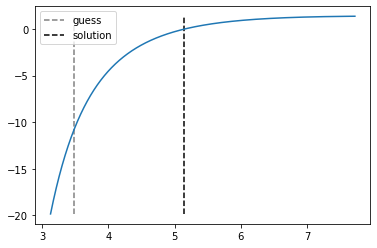

In [5]:
# Settings
lam_0 = 2.5 # initial drip parameter
tau = 5.0 # rate of decay of lambda

# Create Poisson model
lam = lambda t: lam_0*np.exp(-t/tau) # lambda(t)
Lam = lambda t, s: lam_0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau)) # integral
model = ephys.Poisson(lam=lam, Lam=Lam, homogeneous=False)

# Simulate processes
iters = 1000
t_sum = np.zeros(iters)
K = np.zeros(iters)
for i in range(iters):
    t = model.times(interevent=False, s=10.0)
    K[i] = len(t)
    t_sum[i] = np.sum(t)
print('Simulation estimates:')
print('t_sum: {} +/- {}'.format(np.mean(t_sum), np.std(t_sum)))
print('K: {} +/- {}'.format(np.mean(K), np.std(K)))
print()

# Define functions
K = np.mean(K)
t_sum = np.mean(t_sum)
t = 10.0
f = lambda tau: (tau/t)*(K - (1.0/tau)*t_sum)*(np.exp(t/tau) - 1.0) - K
df = lambda tau: (K/t)*(np.exp(t/tau) - 1.0) - (tau*K - t_sum)*np.exp(t/tau)/(t*tau**2)

# Find MLE of tau
print('MLE parameters:')
tau_init = t_sum/K
if t_sum < 0.5*K*t:
    tau_MLE = brentq(f, tau_init, 10000)
    #tau_MLE = broyden1(f, tau_init)
    #tau_MLE = newton(f, tau_init, fprime=df, maxiter=int(1e6), full_output=True)    
else:
    tau_MLE = math.inf
print('tau {:.3e}'.format(tau_MLE))

# Find corresponding MLE of lambda
if tau_MLE < math.inf:
    lam_0_MLE = (K - t_sum/tau_MLE)/t * np.exp(t/tau)
else:
    lam_0_MLE = K/t * np.exp(t/tau)
print('lambda_0 {:.3e}'.format(lam_0_MLE))
print()

# Print ground truth
print('Ground truth parameters:')
print('tau {:.3e}'.format(tau))
print('lambda_0 {:.3e}'.format(lam_0))

# Plot function
tau = np.geomspace(0.9*t_sum/K, 1.5*tau_MLE, num=1000)
plt.plot(tau, f(tau))
plt.vlines(t_sum/K, 
           ymin=f(tau).min(), 
           ymax=f(tau).max(),
           linestyle='--',
           color='black',
           alpha=0.5,
           label='guess')

# Plot solution
if tau_MLE < math.inf:
    plt.vlines(tau_MLE, 
               ymin=f(tau).min(), 
               ymax=f(tau).max(),
               linestyle='--',
               color='black',
               alpha=1.0,
               label='solution')
plt.legend();

#### Marginal likelihood estimation of $\lambda$

In the previous section, we found the maximum likelihood estimates for our parameters, $\lambda_0$ and $\tau$, and then deduced what the current $\lambda$ might be based on those estimates. On the flip side, rather than getting a point estimate for $\lambda$, we could marginalize our probability distribution over all values of our parameters to get a probability density function for $\lambda$ at time $t$, given the sequence of events $t_k$ we have experienced thus far. To do so, first note that $\lambda_0$ and $\tau$ cannot simply be any value but are related by the following equation:

$
\quad \lambda = \lambda_0 e^{\frac{-t}{\tau}}
\Rightarrow \lambda_0 = \lambda e^{\frac{t}{\tau}}
$

where we note that in this case, we fix $\lambda$ as a constant, and constrain the values of $\lambda_0$ and $\tau$ given such $\lambda$. We can model this constraint as a (exponential decay) curve in $(\tau, \lambda_0)$ space, the shape of which depends on the particular value of $\lambda$. Thus, for a given value of $\lambda$, we can calculate its marginal probability by integrating the likelihood function over this curve, thus covering all possible allowed values for our parameters. We then repeat this integration for each value of $\lambda$, each of which generates a new curve in parameter space that defines the constraints. By computing the values of these line integrals over many values of $\lambda$, we can generate an estimate for its marginal probability density function:

$
\quad \vec{r}(\tau) = \tau \hat{i} + \lambda_0 \hat{j} = \tau \hat{i} + \lambda e^{\frac{t}{\tau}} \hat{j}
$

$
\begin{align}
\quad ln(p(\lambda))
&= \int \int p(\lambda \vert \lambda_0, \tau) p(\lambda_0) p(\tau) d\lambda_0 d\tau \\
&= \oint p(\lambda \vert \tau) p(\tau) \left | \vec{r}(\tau) \right | d\tau \\
&= \oint \left ( -\Lambda(t) + \sum_n k_n ln \left ( \Lambda_n(t) \right ) - \sum_n ln(k_n!) \right ) p(\tau) \sqrt{1 + \left ( \dfrac{\lambda t}{\tau} e^{\frac{t}{\tau}} \right )^2} d\tau
\end{align}
$

remembering that, for an integral over a two-dimensional curve parametrized by $\tau$, the infinitesimal step is:

$
\quad dr 
= \left | \vec{r}(\tau) \right | d\tau
= \sqrt{\left ( \dfrac{dx}{d\tau} \right )^2 + \left ( \dfrac{dy}{d\tau} \right )^2} d\tau
$

In [6]:
import scipy.integrate
import scipy.signal

In [18]:
# Settings
lam_0 = 10.0 # initial drip parameter
tau = 5.0 # rate of decay of lambda
t = 10.0 # current time in patch
bin_size = 0.1 # duration of time bins to estimate rate decay
t_bin = np.linspace(0.0, t, num=int(t/bin_size + 1))
tau_lim = [0.1, 1000.0] # limits of integration; p(tau) = 0 outside bounds

# Create Poisson model
lam = lambda t: lam_0*np.exp(-t/tau) # lambda(t)
Lam = lambda t, s: lam_0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau)) # integral
model = ephys.Poisson(lam=lam, Lam=Lam, homogeneous=False)
t_k = model.times(interevent=False, s=t)

# Define components of function to integrate
def get_F(t, t_k, t_bin, lam):
    # Define equation components
    k_n = util.in_interval(t_k, t_bin[:-1], t_bin[1:], query='interval')
    def Lam_n(tau): 
        Lam_ = lambda t1, t2: -lam*np.exp(t/tau)*tau*(np.exp(-t2/tau) - np.exp(-t1/tau)) 
        Lam_n = np.zeros(len(t_bin)-1)
        for i in range(len(t_bin)-1):
            Lam_n[i] = Lam_(t_bin[i], t_bin[i+1])
        return Lam_n

    # Define prior on tau (or really, on (tau, lambda_0))
    def p_0(tau):
        if tau >= tau_lim[0] and tau <= tau_lim[1]:
            return 1.0/(tau_lim[1] - tau_lim[0]) # constant prior
        else:
            return 0.0
    
    # Define numerically stable function to integrate
    def F(tau):
        if t/tau > 5.0:
            return ( np.exp(-lam*tau*(np.exp(t/tau) - 1.0) 
                            + np.sum(k_n*np.log(Lam_n(tau)))
                            - np.sum(np.log(scipy.special.factorial(k_n)))
                            + t/tau)
                     *(lam*t)**0.5/tau
                     *p_0(tau)
                    )
        else:
            return ( np.exp(-lam*tau*(np.exp(t/tau) - 1.0) 
                            + np.sum(k_n*np.log(Lam_n(tau)))
                            - np.sum(np.log(scipy.special.factorial(k_n)))) 
                     *(1.0 + (lam*t/tau**2 * np.exp(t/tau))**2)**0.5
                     *p_0(tau)
                    )
    
    return F

In [34]:
# Estimate marginal probability
lam_ = np.linspace(0.1, 10.0, num=100)
p = np.zeros([len(lam_), len(t_bin)])
for i, tt in enumerate(t_bin):
    print('Calculating marginal probability at time {:.2f}'.format(tt))
    for j, l in enumerate(lam_):
        args = (tt, t_k[t_k <= tt], t_bin[t_bin <= tt], l)
        p[j, i] = scipy.integrate.quad(get_F(tt, t_k[t_k <= tt], t_bin[t_bin <= tt], l), 
                                       tau_lim[0],
                                       tau_lim[1],
                                      )[0]

Calculating marginal probability at time 0.00
Calculating marginal probability at time 0.10
Calculating marginal probability at time 0.20
Calculating marginal probability at time 0.30
Calculating marginal probability at time 0.40
Calculating marginal probability at time 0.50
Calculating marginal probability at time 0.60
Calculating marginal probability at time 0.70
Calculating marginal probability at time 0.80
Calculating marginal probability at time 0.90
Calculating marginal probability at time 1.00


/home/james/anaconda3/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:10: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  # Remove the CWD from sys.path while we load stuff.


Calculating marginal probability at time 1.10
Calculating marginal probability at time 1.20
Calculating marginal probability at time 1.30
Calculating marginal probability at time 1.40
Calculating marginal probability at time 1.50
Calculating marginal probability at time 1.60
Calculating marginal probability at time 1.70
Calculating marginal probability at time 1.80
Calculating marginal probability at time 1.90
Calculating marginal probability at time 2.00
Calculating marginal probability at time 2.10
Calculating marginal probability at time 2.20
Calculating marginal probability at time 2.30
Calculating marginal probability at time 2.40
Calculating marginal probability at time 2.50
Calculating marginal probability at time 2.60
Calculating marginal probability at time 2.70
Calculating marginal probability at time 2.80
Calculating marginal probability at time 2.90
Calculating marginal probability at time 3.00
Calculating marginal probability at time 3.10
Calculating marginal probability a

In [35]:
# Find MLE parameters
lam_MLE = np.zeros([len(t_bin)])

for i, tt in enumerate(t_bin):
    # Calculate variables
    t_sum = np.sum(t_k[t_k <= tt])
    K = np.sum(t_k <= tt)
    
    # Define function
    f = lambda tau: (tau/tt)*(K - (1.0/tau)*t_sum)*(np.exp(tt/tau) - 1.0) - K
    tau_init = t_sum/K
    
    # Find MLE of tau
    if t_sum < 0.5*K*tt:
        tau_MLE = brentq(f, tau_init, 10000)
    else:
        tau_MLE = math.inf

    # Find corresponding MLE of lambda
    if tau_MLE < math.inf:
        lam_MLE[i] = (K - t_sum/tau_MLE)/tt
    else:
        lam_MLE[i] = K/tt

/home/james/anaconda3/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/james/anaconda3/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


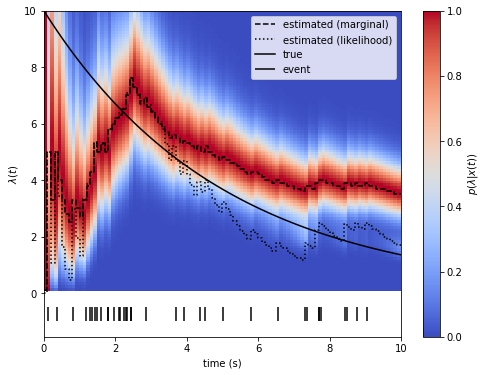

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot likelihood estimates
cmap = plt.get_cmap('coolwarm')
im = ax.pcolormesh(t_bin,
                   lam_,
                   p/p.max(axis=0),
                   cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('$p(\lambda | x(t))$')

# Plot MLE from marginalization
ax.step(t_bin,
        lam_[np.argmax(p, axis=0)],
        color='black',
        linestyle='--',
        label='estimated (marginal)')

# Plot MLE from likelihood
ax.step(t_bin,
        lam_MLE,
        color='black',
        linestyle=':',
        label='estimated (likelihood)')

# Plot true parameter
ax.plot(t_bin, 
        lam_0*np.exp(-t_bin/tau), 
        color='black',
        label='true')

# Plot events
ax.vlines(t_k, 
          ymin=-0.1*ax.get_ylim()[1],
          ymax=-0.05*ax.get_ylim()[1],
          color='black',
          label='event')

# Set labels
ax.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('$\lambda(t)$');

### Multiple sequence parameter estimation
While useful to estimate the parameters from a single sequence of events, we should take advantage of the fact that animals will experience multiple sequences by visiting multiple patches (with the same underlying parameters).

#### Equal sequence durations
First, consider the case where the each sequence is drawn from the same interval $[0, t]$.

In [201]:
# Settings
lam_0 = 5.0 # initial drip parameter
tau = 10.0 # rate of decay of lambda
T = 30.0 # current time in patch
bin_size = 0.5 # duration of time bins to estimate rate decay
t_bin = np.linspace(0.0, T, num=int(T/bin_size + 1))
M = 21 # number of sequences
tau_lim = [1.0, 100.0] # limits of integration; p(tau) = 0 outside bounds

# Create Poisson model
lam = lambda t: lam_0*np.exp(-t/tau) # lambda(t)
Lam = lambda t, s: lam_0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau)) # integral
model = ephys.Poisson(lam=lam, Lam=Lam, homogeneous=False)

In [202]:
# Simulate multiple patches
t_k = []
lam_MLE = np.zeros([M, len(t_bin)-1])
for m in range(M):
    t_k.append(model.times(interevent=False, s=T))
    
    for i, t in enumerate(t_bin[1:]):
        # Calculate means of variables
        t_k_ = np.hstack(t_k)
        t_sum_mean = (1.0/(m+1))*np.sum(t_k_[t_k_ <= t])
        K_mean = (1.0/(m+1))*np.sum(t_k_ <= t)

        # Define function
        f = lambda tau: (tau/t)*(K_mean - (1.0/tau)*t_sum_mean)*(np.exp(t/tau) - 1.0) - K_mean
        tau_init = t_sum_mean/K_mean

        # Find MLE of tau
        if t_sum_mean < 0.5*K_mean*t:
            tau_MLE = brentq(f, tau_init, 10000)
        else:
            tau_MLE = math.inf

        # Find corresponding MLE of lambda
        if tau_MLE < math.inf:
            lam_MLE[m, i] = (K_mean - t_sum_mean/tau_MLE)/t
        else:
            lam_MLE[m, i] = K_mean/t

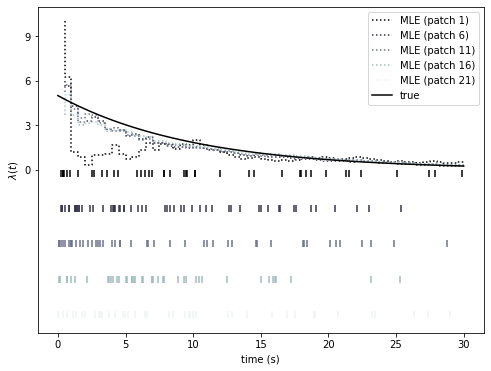

In [203]:
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.get_cmap('bone')

# Plot MLE from likelihood
for m in range(0, M, 5):
    ax.step(t_bin[1:],
            lam_MLE[m, :],
            color=cmap(m/M),
            linestyle=':',
            label='MLE (patch {})'.format(m+1))

# Plot true parameter
ax.plot(t_bin, 
        lam_0*np.exp(-t_bin/tau), 
        color='black',
        label='true')

# Plot events
for m in range(0, M, 5):
    ax.vlines(t_k[m], 
              ymin=-10*((m+1)/M),
              ymax=-10*(m/M),
              color=cmap(m/M))
              #label='event')

# Set labels
ax.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('$\lambda(t)$')
ax.set_yticks(np.arange(0, ax.get_ylim()[1], ax.get_ylim()[1]//3));

In [204]:
# Define numerically stable function to integrate.
# This represents f(tau) = p(lambda)p(tau)dr.
def get_F(t, t_k, t_bin, lam):
    # Define function components
    m = len(t_k) # number of sequences observed
    k_n = np.zeros([m, len(t_bin)-1])
    for i in range(m):
        k_n[i] = util.in_interval(t_k[i], t_bin[:-1], t_bin[1:], query='interval')
    def Lam_n(tau, lam=lam): 
        Lam_ = lambda t1, t2: -lam*np.exp(t/tau)*tau*(np.exp(-t2/tau) - np.exp(-t1/tau))
        Lam_n = np.zeros(len(t_bin)-1)
        for i in range(len(t_bin)-1):
            Lam_n[i] = Lam_(t_bin[i], t_bin[i+1])
        return Lam_n

    # Define prior on tau (or really, on (tau, lambda_0)).
    # This essentially defines a range for the integration,
    # unless p_0 is a normalized distribution over [-inf, inf].
    def p_0(tau):
        if tau >= tau_lim[0] and tau <= tau_lim[1]:
            return 1.0/(tau_lim[1] - tau_lim[0]) # constant prior
        else:
            return 0.0
    
    # Define exponent in p(lambda)
    def log_sum(tau, lam=lam):
        return (-m*lam*tau*(np.exp(t/tau) - 1.0) 
                + np.sum(np.sum(k_n, axis=0)*np.log(Lam_n(tau, lam=lam)))
                - np.sum(np.log(factorial(k_n)))
               )
    
    # Find constant to subtract from exponent for numerical stability.
    # Disregarding this leads to numerical underflow and all zero
    # probabilities at large m or t/tau. We must search over parameter space 
    # (lambda, tau) for the maximum exponent to avoid numerical overflow 
    # while integrating.
    C = -np.inf
    for i, tau_ in enumerate(np.geomspace(tau_lim[0], tau_lim[1], 10)):
        for j, lam_ in enumerate(np.linspace(lam_range[0], lam_range[1], 10)):
            s = log_sum(tau_, lam_)
            if s > C:
                C = s
  
    # Numerically stable function to integrate
    def F(tau):
        if t/tau > 5.0:
            # Approximate if e^(t/tau) >> 1
            return (np.exp(log_sum(tau) + t/tau - C)
                    *((lam*t)**0.5/tau)
                    *(p_0(tau))
                   )
        else:
            # Otherwise, compute exact function
            return (np.exp(log_sum(tau) - C)
                    *((1.0 + (lam*t/tau**2 * np.exp(t/tau))**2)**0.5)
                    *(p_0(tau))
                   )
    
    return F

In [207]:
# Estimate marginal probability
lam_range = np.linspace(0.1, 10.0, num=50)
p = np.zeros([M, len(lam_range), len(t_bin)])
t_start = time.time()
for m in range(M):
    print('Calculating marginal probability for sequence {}...'.format(m+1), end=' ')
    for i, t in enumerate(t_bin):
        for j, l in enumerate(lam_range):
            p[m, j, i] = scipy.integrate.quad(get_F(t, t_k[:m+1], t_bin[t_bin <= t], l), 
                                              tau_lim[0],
                                              tau_lim[1]
                                             )[0]
    print('done.')
    eta = (time.time()-t_start)/(m+1)*(M-m-1)
    print('Estimated time remaining: {}'
          .format(timedelta(seconds=(time.time()-t_start)/(m+1)*(M - m - 1))))

Calculating marginal probability for sequence 1... done.
Estimated time remaining: 0:29:42.234645
Calculating marginal probability for sequence 2... done.
Estimated time remaining: 0:28:52.868618
Calculating marginal probability for sequence 3... 

/home/james/anaconda3/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  # This is added back by InteractiveShellApp.init_path()


done.
Estimated time remaining: 0:27:26.946253
Calculating marginal probability for sequence 4... done.
Estimated time remaining: 0:26:01.683835
Calculating marginal probability for sequence 5... done.
Estimated time remaining: 0:24:36.777848
Calculating marginal probability for sequence 6... done.
Estimated time remaining: 0:23:08.338258
Calculating marginal probability for sequence 7... done.
Estimated time remaining: 0:21:38.380357
Calculating marginal probability for sequence 8... done.
Estimated time remaining: 0:20:09.646750
Calculating marginal probability for sequence 9... done.
Estimated time remaining: 0:18:41.259904
Calculating marginal probability for sequence 10... done.
Estimated time remaining: 0:17:13.617232
Calculating marginal probability for sequence 11... done.
Estimated time remaining: 0:15:44.474693
Calculating marginal probability for sequence 12... done.
Estimated time remaining: 0:14:19.039635
Calculating marginal probability for sequence 13... done.
Estimated 

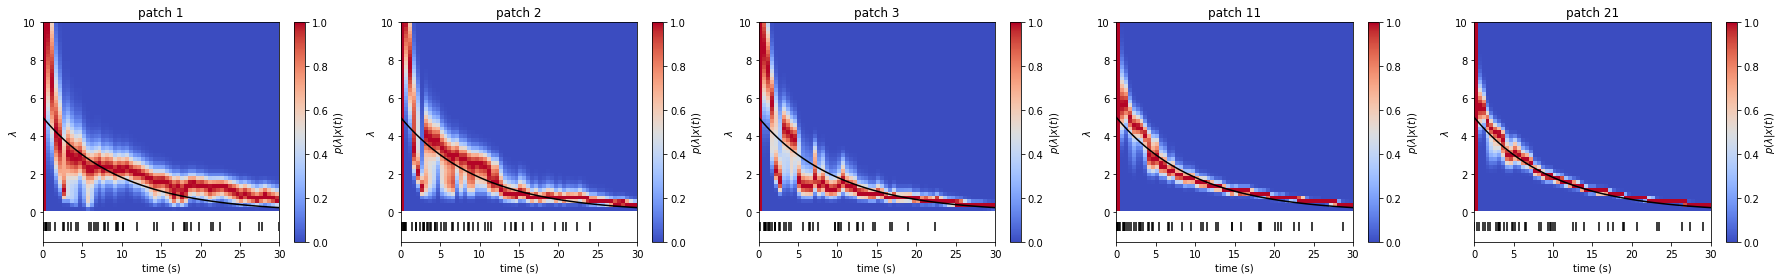

In [226]:
M_plot = [0, 1, 2, 10, 20]
fig, ax = plt.subplots(1, len(M_plot), figsize=(len(M_plot)*5, 4))

cmap = plt.get_cmap('coolwarm')
for i, m in enumerate(M_plot):
    ax_ = ax[i]
    
    # Plot likelihood estimate at sequence m
    im = ax_.pcolormesh(t_bin,
                        lam_range,
                        p[m]/p[m].max(axis=0),
                        cmap=cmap)
    cbar = fig.colorbar(im, ax=ax_)
    cbar.set_label('$p(\lambda | x(t))$')
    
    # Plot true parameter
    ax_.plot(t_bin, 
             lam_0*np.exp(-t_bin/tau), 
             color='black',
             label='true')

    # Plot events of sequence m
    ax_.vlines(t_k[m], 
               ymin=-0.1*ax_.get_ylim()[1],
               ymax=-0.05*ax_.get_ylim()[1],
               color='black',
               label='event')
    
    # Label axis
    ax_.set_title('patch {}'.format(m+1))
    ax_.set_xlabel('time (s)')
    ax_.set_ylabel('$\lambda$')
    
plt.tight_layout()

#### Consective sequences
Next, let's consider an observer who uses both 1) the current sequence information at time $t$ and 2) the previous sequence information for the entire sequence durations. To simplify slightly, we will assume all previous sequences have the same length, $T$, although we could easily adapt to the case where sequence durations differ.

In [771]:
# Settings
lam_0 = 5.0 # initial drip parameter
tau = 10.0 # rate of decay of lambda
T = 30.0 # current time in patch
bin_size = 0.5 # duration of time bins to estimate rate decay
t_bin = np.linspace(0.0, T, num=int(T/bin_size + 1))
M = 21 # number of sequences
tau_lim = [1.0, 100.0] # limits of integration; p(tau) = 0 outside bounds

# Create Poisson model
lam = lambda t: lam_0*np.exp(-t/tau) # lambda(t)
Lam = lambda t, s: lam_0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau)) # integral
model = ephys.Poisson(lam=lam, Lam=Lam, homogeneous=False)

In [772]:
# Simulate multiple patches
t_k = []
lam_MLE = np.zeros([M, len(t_bin)-1])
for m in range(M):
    t_k.append(model.times(interevent=False, s=T))
    
    for i, t in enumerate(t_bin[1:]):
        # Calculate variables
        if m > 0:
            t_k_ = np.hstack(t_k[:-1]) # use all times from previous sequences
            K_ = len(t_k_)
            t_k_ = np.hstack([t_k_, t_k[-1][t_k[-1] <= t]]) # add times from current sequence
            K_m = np.sum(t_k[-1] <= t)
        else:
            t_k_ = t_k[0][t_k[0] <= t]
            K_ = 0
            K_m = len(t_k_)
        t_sum = np.sum(t_k_)
        K = K_ + K_m

        # Define function
        #f = lambda tau: (tau/t)*(K_mean - (1.0/tau)*t_sum_mean)*(np.exp(t/tau) - 1.0) - K_mean
        f = lambda tau: ( ((m+1) - m*np.exp(-T/tau) - np.exp(-t/tau))
                          /(m*T*np.exp(-T/tau) + t*np.exp(-t/tau))
                          *(K*tau - t_sum)
                          - K
                        )
        tau_init = t_sum/K

        # Find MLE of tau
        if t_sum < 0.5*(K_*m*T + K_m*t):
            tau_MLE = brentq(f, tau_init, 100000)
        else:
            tau_MLE = math.inf

        # Find corresponding MLE of lambda
        if tau_MLE < math.inf:
            lam_MLE[m, i] = (K*np.exp(-t/tau_MLE))/(tau_MLE*((m+1) - m*np.exp(-T/tau_MLE) - np.exp(-t/tau_MLE)))
        else:
            lam_MLE[m, i] = K/(m*T + t)

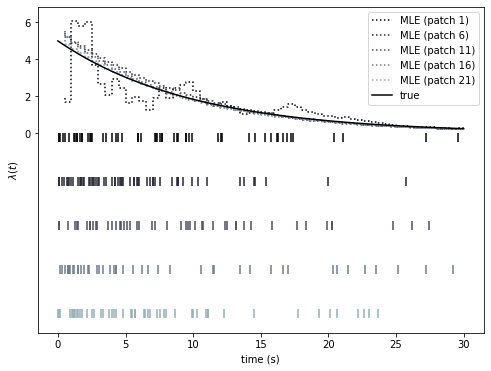

In [773]:
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.get_cmap('bone')
cmap = colors.LinearSegmentedColormap.from_list('bone_rescaled',
                                                cmap(np.linspace(0.0, 0.7, 100)))

# Plot MLE from likelihood
for m in range(0, M, 5):
    ax.step(t_bin[1:],
            lam_MLE[m, :],
            color=cmap(m/M),
            linestyle=':',
            label='MLE (patch {})'.format(m+1))

# Plot true parameter
ax.plot(t_bin, 
        lam_0*np.exp(-t_bin/tau), 
        color='black',
        label='true')

# Plot events
for m in range(0, M, 5):
    ax.vlines(t_k[m], 
              ymin=-10*((m+1)/M),
              ymax=-10*(m/M),
              color=cmap(m/M))
              #label='event')

# Set labels
ax.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('$\lambda(t)$')
ax.set_yticks(np.arange(0, ax.get_ylim()[1], ax.get_ylim()[1]//3));

In [774]:
# Define numerically stable function to integrate.
# This represents f(tau) = p(lambda)p(tau)dr.
def get_F(t, t_k, t_bin, lam):
    # Define function components
    m = len(t_k) # number of sequences observed
    t_k[-1] = t_k[-1][t_k[-1] <= t] # current sequence
    k_n = np.zeros([m, len(t_bin)-1])
    for i in range(m):
        k_n[i] = util.in_interval(t_k[i], t_bin[:-1], t_bin[1:], query='interval')
    def Lam_n(tau, lam=lam): 
        Lam_ = lambda t1, t2: -lam*np.exp(t/tau)*tau*(np.exp(-t2/tau) - np.exp(-t1/tau))
        Lam_n = np.zeros(len(t_bin)-1)
        for i in range(len(t_bin)-1):
            Lam_n[i] = Lam_(t_bin[i], t_bin[i+1])
        return Lam_n

    # Define prior on tau (or really, on (tau, lambda_0)).
    # This essentially defines a range for the integration,
    # unless p_0 is a normalized distribution over [-inf, inf].
    def p_0(tau):
        if tau >= tau_lim[0] and tau <= tau_lim[1]:
            return 1.0/(tau_lim[1] - tau_lim[0]) # constant prior
        else:
            return 0.0
    
    # Define exponent in p(lambda)
    def log_sum(tau, lam=lam):
        return (-(m-1)*lam*np.exp(t/tau)*tau*(1.0 - np.exp(-T/tau))
                - lam*tau*(np.exp(t/tau) - 1.0)
                + np.sum(np.sum(k_n, axis=0)*np.log(Lam_n(tau, lam=lam)))
                - np.sum(np.log(factorial(k_n)))
                + np.sum(t_bin > t) # correct for zeros in k_n[-1]
               )
    
    # Find constant to subtract from exponent for numerical stability.
    # Disregarding this leads to numerical underflow and all zero
    # probabilities at large m or t/tau. We must search over parameter space 
    # (lambda, tau) for the maximum exponent to avoid numerical overflow 
    # while integrating.
    C = -np.inf
    for i, tau_ in enumerate(np.geomspace(tau_lim[0], tau_lim[1], 10)):
        for j, lam_ in enumerate(np.linspace(lam_range[0], lam_range[1], 10)):
            s = log_sum(tau_, lam_)
            if s > C:
                C = s
    
    # Numerically stable function to integrate
    def F(tau):
        if t/tau > 5.0:
            # Approximate if e^(t/tau) >> 1
            return (np.exp(log_sum(tau) + t/tau - C)
                    *((lam*t)**0.5/tau)
                    *(p_0(tau))
                   )
        else:
            # Otherwise, compute exact function
            return (np.exp(log_sum(tau) - C)
                    *((1.0 + (lam*t/tau**2 * np.exp(t/tau))**2)**0.5)
                    *(p_0(tau))
                   )
    
    return F

In [775]:
# Estimate marginal probability
lam_range = np.linspace(0.1, 10.0, num=50)
p = np.zeros([M, len(lam_range), len(t_bin)])
t_start = time.time()
for m in range(M):
    print('Calculating marginal probability for sequence {}...'.format(m+1), end=' ')
    for i, t in enumerate(t_bin):
        for j, l in enumerate(lam_range):
            p[m, j, i] = scipy.integrate.quad(get_F(t, t_k[:m+1], t_bin, l), 
                                              tau_lim[0],
                                              tau_lim[1]
                                             )[0]
    print('done.')
    eta = (time.time()-t_start)/(m+1)*(M-m-1)
    print('Estimated time remaining: {}'
          .format(timedelta(seconds=(time.time()-t_start)/(m+1)*(M - m - 1))))

Calculating marginal probability for sequence 1... done.
Estimated time remaining: 1:12:11.180725
Calculating marginal probability for sequence 2... done.
Estimated time remaining: 1:07:43.757209
Calculating marginal probability for sequence 3... done.
Estimated time remaining: 1:05:30.142756
Calculating marginal probability for sequence 4... done.
Estimated time remaining: 1:03:04.435940
Calculating marginal probability for sequence 5... done.
Estimated time remaining: 1:00:19.516396
Calculating marginal probability for sequence 6... done.
Estimated time remaining: 0:57:40.026772
Calculating marginal probability for sequence 7... done.
Estimated time remaining: 0:54:24.510047
Calculating marginal probability for sequence 8... done.
Estimated time remaining: 0:50:56.579587
Calculating marginal probability for sequence 9... done.
Estimated time remaining: 0:47:22.238036
Calculating marginal probability for sequence 10... done.
Estimated time remaining: 0:43:43.344982
Calculating margina

/home/james/anaconda3/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in double_scalars


done.
Estimated time remaining: 0:35:59.216522
Calculating marginal probability for sequence 13... done.
Estimated time remaining: 0:31:45.808829
Calculating marginal probability for sequence 14... done.
Estimated time remaining: 0:27:33.733760
Calculating marginal probability for sequence 15... done.
Estimated time remaining: 0:23:25.934040
Calculating marginal probability for sequence 16... done.
Estimated time remaining: 0:19:20.975196
Calculating marginal probability for sequence 17... done.
Estimated time remaining: 0:15:20.092206
Calculating marginal probability for sequence 18... done.
Estimated time remaining: 0:11:23.867484
Calculating marginal probability for sequence 19... done.
Estimated time remaining: 0:07:32.280630
Calculating marginal probability for sequence 20... done.
Estimated time remaining: 0:03:44.299343
Calculating marginal probability for sequence 21... done.
Estimated time remaining: 0:00:00


/home/james/anaconda3/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


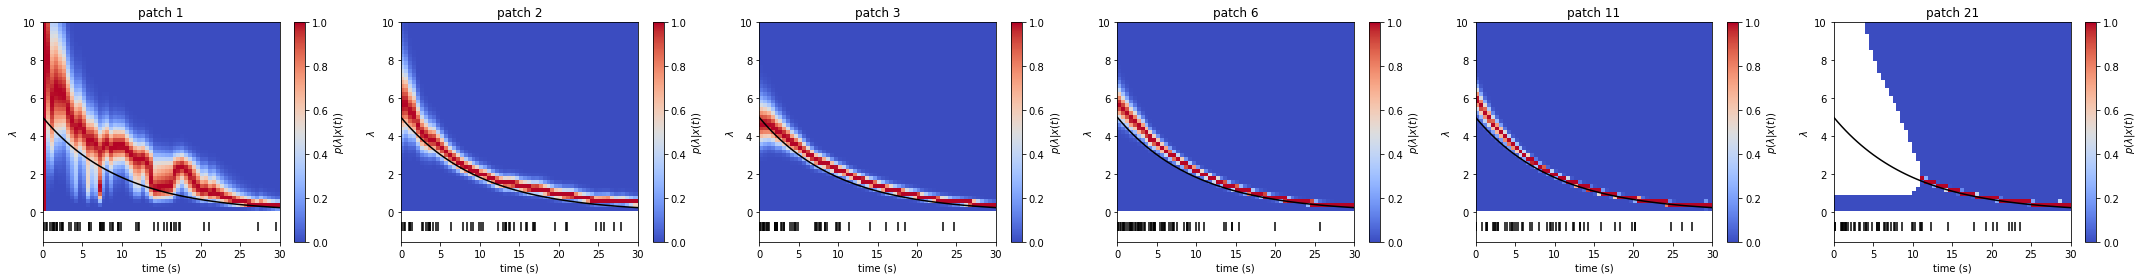

In [776]:
M_plot = [0, 1, 2, 5, 10, 20]
fig, ax = plt.subplots(1, len(M_plot), figsize=(len(M_plot)*5, 4))

cmap = plt.get_cmap('coolwarm')
for i, m in enumerate(M_plot):
    ax_ = ax[i]
    
    # Plot likelihood estimate at sequence m
    im = ax_.pcolormesh(t_bin,
                        lam_range,
                        p[m]/p[m].max(axis=0),
                        cmap=cmap)
    cbar = fig.colorbar(im, ax=ax_)
    cbar.set_label('$p(\lambda | x(t))$')
    
    # Plot true parameter
    ax_.plot(t_bin, 
             lam_0*np.exp(-t_bin/tau), 
             color='black',
             label='true')

    # Plot events of sequence m
    ax_.vlines(t_k[m], 
               ymin=-0.1*ax_.get_ylim()[1],
               ymax=-0.05*ax_.get_ylim()[1],
               color='black',
               label='event')
    
    # Label axis
    ax_.set_title('patch {}'.format(m+1))
    ax_.set_xlabel('time (s)')
    ax_.set_ylabel('$\lambda$')
    
plt.tight_layout()

### Partially-observable parameter estimation
Let's now consider what the animal actually observes given the construction of the task.

#### Estimating with knowledge of hidden process

##### Naive method
The problem with this estimation is that the probability is calculated for $n$ drips between reward times (with the $n$th drip occurring anytime between rewards), but not for $n$ drips at exactly the reward time (with the $n$th drip occurring at exactly the reward time). This leads to an underestimation of $\tau$ (i.e. overestimation of decay) and thus underestimation of $\lambda$.

In [606]:
# Settings
lam_0 = 10.0 # initial drip parameter
tau = 10.0 # rate of decay of lambda
T = 30.0 # current time in patch
bin_size = 0.5 # duration of time bins to estimate rate decay
t_bin = np.linspace(0.0, T, num=int(T/bin_size + 1))
M = 21 # number of sequences
tau_lim = [1.0, 100.0] # limits of integration; p(tau) = 0 outside bounds
v_reward = 2.0
v_drip = 0.2
n_drip = int(v_reward/v_drip)

# Create Poisson model
lam = lambda t: lam_0*np.exp(-t/tau) # lambda(t)
Lam = lambda t, s: lam_0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau)) # integral
model = ephys.Poisson(lam=lam, Lam=Lam, homogeneous=False)

In [607]:
# Simulate multiple patches
t_k = []
lam_MLE = np.zeros([M, len(t_bin)-1])
tau_MLE = np.zeros([M, len(t_bin)-1])
for m in range(M): 
    # Simulate new sequence
    t_k.append(model.times(interevent=False, s=T)[n_drip-1::n_drip])
    
    for i, t in enumerate(t_bin[1:]):
        # Calculate means of variables
        K = np.sum(np.hstack(t_k) <= t)
        
        def alpha_k(tau):
            alpha = lambda t1, t2: (t1*np.exp(-t1/tau) - t2*np.exp(-t2/tau))/(np.exp(-t1/tau) - np.exp(-t2/tau))
            alpha_k = []
            for t_k_ in t_k:
                t_k_t = np.insert(t_k_[t_k_ <= t], 0, 0.0)
                alpha_k.append(alpha(t_k_t[:-1], t_k_t[1:]))
            return np.hstack(alpha_k)

        # Define function
        f = lambda tau: -(1.0/t)*np.sum(alpha_k(tau))*(np.exp(t/tau) - 1.0) - K
        tau_init = 0.1

        # Find MLE of tau
        if K > 0: # avoid trivial equation
            #idx = np.argwhere(np.hstack(t_k) <= t)
            #if np.sum(np.hstack(t_k)[idx]) < 0.5*K*t:
            try:
                tau_MLE[m, i] = brentq(f, tau_init, 10000)
            #else:
            except ValueError:
                tau_MLE[m, i] = math.inf
        else:
            tau_MLE[m, i] = math.inf

        # Find corresponding MLE of lambda
        if tau_MLE[m, i] < math.inf:
            lam_MLE[m, i] = (1.0/(m+1))*(n_drip*K)/(tau_MLE[m, i]*(np.exp(t/tau_MLE[m, i]) - 1.0))
        else:
            lam_MLE[m, i] = (1.0/(m+1))*n_drip*K/t

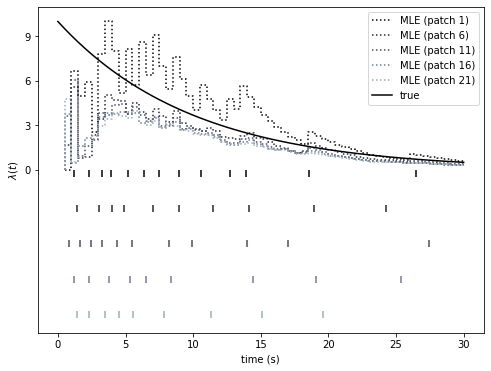

In [608]:
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.get_cmap('bone')
cmap = colors.LinearSegmentedColormap.from_list('bone_rescaled',
                                                cmap(np.linspace(0.0, 0.7, 100)))

# Plot MLE from likelihood
for m in range(0, M, 5):
    ax.step(t_bin[1:],
            lam_MLE[m, :],
            color=cmap(m/M),
            linestyle=':',
            label='MLE (patch {})'.format(m+1))

# Plot true parameter
ax.plot(t_bin, 
        lam_0*np.exp(-t_bin/tau), 
        color='black',
        label='true')

# Plot events
for m in range(0, M, 5):
    ax.vlines(t_k[m], 
              ymin=-10*((m+1)/M),
              ymax=-10*(m/M),
              color=cmap(m/M))
              #label='event')

# Set labels
ax.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('$\lambda(t)$')
ax.set_yticks(np.arange(0, ax.get_ylim()[1], ax.get_ylim()[1]//3));

In [609]:
# Define numerically stable function to integrate.
# This represents f(tau) = p(lambda)p(tau)dr.
def get_F(t, t_k, t_bin, lam):
    # Define function components
    m = len(t_k) # number of sequences observed
    K = 0 # total number of events observed
    for t_k_ in t_k:
        K += len(t_k_)
        
    def Lam_n(tau, lam=lam): 
        Lam_ = lambda t1, t2: -lam*np.exp(t/tau)*tau*(np.exp(-t2/tau) - np.exp(-t1/tau))
        Lam_n = []
        for t_k_ in t_k:
            t_k_ = t_k_[t_k_ <= t]
            if len(t_k_) > 0:
                t_k_ = np.insert(t_k_, 0, 0.0)
                Lam_n.append(Lam_(t_k_[:-1], t_k_[1:]))
        if len(Lam_n) > 0:
            return np.hstack(Lam_n)
        else:
            return np.nan

    # Define prior on tau (or really, on (tau, lambda_0)).
    # This essentially defines a range for the integration,
    # unless p_0 is a normalized distribution over [-inf, inf].
    def p_0(tau):
        if tau >= tau_lim[0] and tau <= tau_lim[1]:
            return 1.0/(tau_lim[1] - tau_lim[0]) # constant prior
        else:
            return 0.0
    
    # Define exponent in p(lambda)
    def log_sum(tau, lam=lam):
        return (-m*lam*tau*(np.exp(t/tau) - 1.0) 
                + np.sum(n_drip*np.log(Lam_n(tau, lam=lam)))
                - K*(np.log(factorial(n_drip)))
               )
    
    # Find constant to subtract from exponent for numerical stability.
    # Disregarding this leads to numerical underflow and all zero
    # probabilities at large m or t/tau. We must search over parameter space 
    # (lambda, tau) for the maximum exponent to avoid numerical overflow 
    # while integrating.
    C = -np.inf
    for i, tau_ in enumerate(np.geomspace(tau_lim[0], tau_lim[1], 10)):
        for j, lam_ in enumerate(np.linspace(lam_range[0], lam_range[1], 10)):
            s = log_sum(tau_, lam_)
            if s > C:
                C = s
  
    # Numerically stable function to integrate
    def F(tau):
        if t/tau > 5.0:
            # Approximate if e^(t/tau) >> 1
            return (np.exp(log_sum(tau) + t/tau - C)
                    *((lam*t)**0.5/tau)
                    *(p_0(tau))
                   )
        else:
            # Otherwise, compute exact function
            return (np.exp(log_sum(tau) - C)
                    *((1.0 + (lam*t/tau**2 * np.exp(t/tau))**2)**0.5)
                    *(p_0(tau))
                   )
    
    return F

In [610]:
# Estimate marginal probability
lam_range = np.linspace(0.1, 10.0, num=50)
p = np.zeros([M, len(lam_range), len(t_bin)])
t_start = time.time()
for m in range(M):
    print('Calculating marginal probability for sequence {}...'.format(m+1), end=' ')
    for i, t in enumerate(t_bin):
        for j, l in enumerate(lam_range):
            p[m, j, i] = scipy.integrate.quad(get_F(t, t_k[:m+1], t_bin[t_bin <= t], l), 
                                              tau_lim[0],
                                              tau_lim[1]
                                             )[0]
    print('done.')
    eta = (time.time()-t_start)/(m+1)*(M-m-1)
    print('Estimated time remaining: {}'
          .format(timedelta(seconds=(time.time()-t_start)/(m+1)*(M - m - 1))))

Calculating marginal probability for sequence 1... 

/home/james/anaconda3/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # This is added back by InteractiveShellApp.init_path()
/home/james/anaconda3/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  # This is added back by InteractiveShellApp.init_path()


done.
Estimated time remaining: 0:21:05.273976
Calculating marginal probability for sequence 2... done.
Estimated time remaining: 0:23:50.788426
Calculating marginal probability for sequence 3... done.
Estimated time remaining: 0:25:51.143533
Calculating marginal probability for sequence 4... done.
Estimated time remaining: 0:27:23.011668
Calculating marginal probability for sequence 5... done.
Estimated time remaining: 0:28:28.997720
Calculating marginal probability for sequence 6... done.
Estimated time remaining: 0:29:25.405530
Calculating marginal probability for sequence 7... done.
Estimated time remaining: 0:30:06.706884
Calculating marginal probability for sequence 8... done.
Estimated time remaining: 0:30:18.972893
Calculating marginal probability for sequence 9... done.
Estimated time remaining: 0:30:12.773153
Calculating marginal probability for sequence 10... done.
Estimated time remaining: 0:29:45.976364
Calculating marginal probability for sequence 11... done.
Estimated ti

/home/james/anaconda3/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  # This is added back by InteractiveShellApp.init_path()


done.
Estimated time remaining: 0:00:00


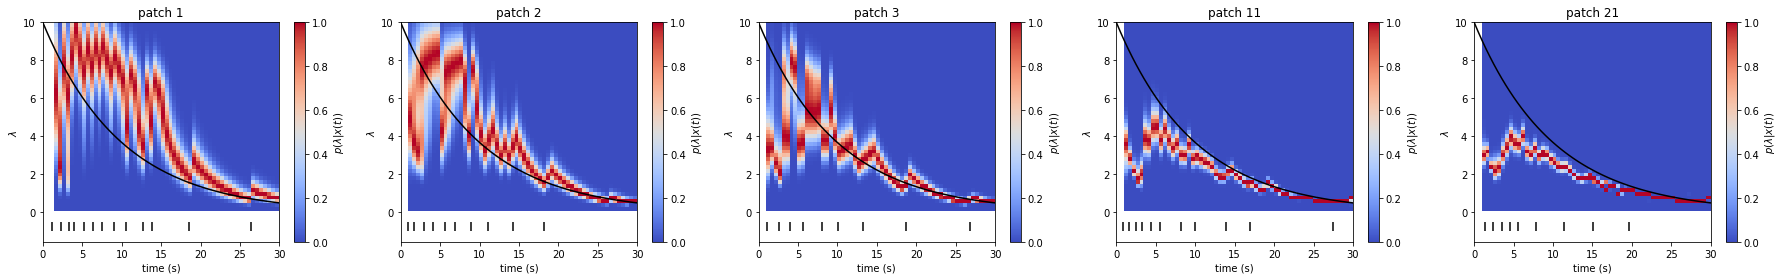

In [611]:
M_plot = [0, 1, 2, 10, 20]
fig, ax = plt.subplots(1, len(M_plot), figsize=(len(M_plot)*5, 4))

cmap = plt.get_cmap('coolwarm')
for i, m in enumerate(M_plot):
    ax_ = ax[i]
    
    # Plot likelihood estimate at sequence m
    im = ax_.pcolormesh(t_bin,
                        lam_range,
                        p[m]/p[m].max(axis=0),
                        cmap=cmap)
    cbar = fig.colorbar(im, ax=ax_)
    cbar.set_label('$p(\lambda | x(t))$')
    
    # Plot true parameter
    ax_.plot(t_bin, 
             lam_0*np.exp(-t_bin/tau), 
             color='black',
             label='true')

    # Plot events of sequence m
    ax_.vlines(t_k[m], 
               ymin=-0.1*ax_.get_ylim()[1],
               ymax=-0.05*ax_.get_ylim()[1],
               color='black',
               label='event')
    
    # Label axis
    ax_.set_title('patch {}'.format(m+1))
    ax_.set_xlabel('time (s)')
    ax_.set_ylabel('$\lambda$')
    
plt.tight_layout()

##### Improved method
Instead, we can exploit our knowledge that the $k$th drip occurs exactly at the reward time, improving our estimation of the underlying parameters.

#### Estimating without knowledge of hidden process
We can instead reduce the hidden process to the observed process with a Poisson rate scaled by `n_drip`. This allows us to use the exact equation by taking the limit as the bin size goes to zero (around reward times).

In [628]:
# Settings
lam_0 = 10.0 # initial drip parameter
tau = 10.0 # rate of decay of lambda
T = 30.0 # current time in patch
bin_size = 0.5 # duration of time bins to estimate rate decay
t_bin = np.linspace(0.0, T, num=int(T/bin_size + 1))
M = 21 # number of sequences
tau_lim = [1.0, 100.0] # limits of integration; p(tau) = 0 outside bounds
v_reward = 2.0
v_drip = 0.2
n_drip = int(v_reward/v_drip)

# Create Poisson model
lam = lambda t: lam_0*np.exp(-t/tau) # lambda(t)
Lam = lambda t, s: lam_0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau)) # integral
model = ephys.Poisson(lam=lam, Lam=Lam, homogeneous=False)

In [651]:
# Simulate multiple patches
t_k = []
tau_MLE = np.zeros([M, len(t_bin)-1])
lam_MLE = np.zeros([M, len(t_bin)-1])
for m in range(M): 
    # Simulate new sequence
    t_k.append(model.times(interevent=False, s=T)[n_drip-1::n_drip])
    
    for i, t in enumerate(t_bin[1:]):
        # Calculate means of variables
        t_k_ = np.hstack(t_k)
        K = np.sum(t_k_ <= t)
        t_sum = np.sum(t_k_[t_k_ <= t])
        
        def alpha_k(tau):
            alpha = lambda t1, t2: (t1*np.exp(-t1/tau) - t2*np.exp(-t2/tau))/(np.exp(-t1/tau) - np.exp(-t2/tau))
            alpha_k = []
            for t_k_ in t_k:
                t_k_t = np.insert(t_k_[t_k_ <= t], 0, 0.0)
                alpha_k.append(alpha(t_k_t[:-1], t_k_t[1:]))
            return np.hstack(alpha_k)

        # Define function
        #f = lambda tau: -(1.0/t)*np.sum(alpha_k(tau))*(np.exp(t/tau) - 1.0) - K
        # tau_init = 0.1
        f = lambda tau: (1.0/t)*(K*tau - t_sum)*(np.exp(t/tau) - 1.0) - K
        tau_init = t_sum/K

        # Find MLE of tau
        #try:
        if t_sum < 0.5*K*t:
            tau_MLE[m, i] = brentq(f, tau_init, 1e6)
        #except ValueError:
        else:
            tau_MLE[m, i] = math.inf

        # Find corresponding MLE of lambda
        if tau_MLE[m, i] < math.inf:
            lam_MLE[m, i] = (1.0/(m+1))*(n_drip*K)/(tau_MLE[m, i]*(np.exp(t/tau_MLE[m, i]) - 1.0))
        else:
            lam_MLE[m, i] = (1.0/(m+1))*n_drip*K/t

/home/james/anaconda3/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


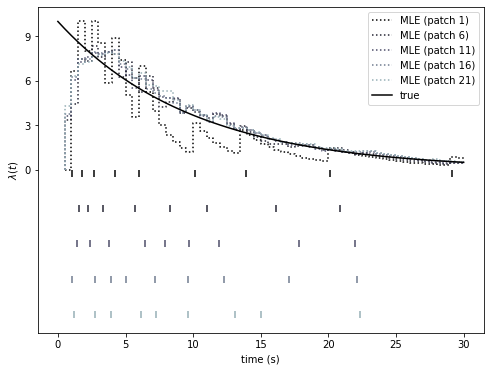

In [653]:
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.get_cmap('bone')
cmap = colors.LinearSegmentedColormap.from_list('bone_rescaled',
                                                cmap(np.linspace(0.0, 0.7, 100)))

# Plot MLE from likelihood
for m in range(0, M, 5):
    ax.step(t_bin[1:],
            lam_MLE[m, :],
            color=cmap(m/M),
            linestyle=':',
            label='MLE (patch {})'.format(m+1))

# Plot true parameter
ax.plot(t_bin, 
        lam_0*np.exp(-t_bin/tau), 
        color='black',
        label='true')

# Plot events
for m in range(0, M, 5):
    ax.vlines(t_k[m], 
              ymin=-10*((m+1)/M),
              ymax=-10*(m/M),
              color=cmap(m/M))
              #label='event')

# Set labels
ax.legend()
ax.set_xlabel('time (s)')
ax.set_ylabel('$\lambda(t)$')
ax.set_yticks(np.arange(0, ax.get_ylim()[1], ax.get_ylim()[1]//3));

In [654]:
# Define numerically stable function to integrate.
# This represents f(tau) = p(lambda)p(tau)dr.
def get_F(t, t_k, t_bin, lam):
    # Transform lambda to observed process
    lam /= (v_reward/v_drip)
    
    # Define function components
    m = len(t_k) # number of sequences observed
    k_n = np.zeros([m, len(t_bin)-1])
    for i in range(m):
        k_n[i] = util.in_interval(t_k[i], t_bin[:-1], t_bin[1:], query='interval')
    def Lam_n(tau, lam=lam): 
        Lam_ = lambda t1, t2: -lam*np.exp(t/tau)*tau*(np.exp(-t2/tau) - np.exp(-t1/tau))
        Lam_n = np.zeros(len(t_bin)-1)
        for i in range(len(t_bin)-1):
            Lam_n[i] = Lam_(t_bin[i], t_bin[i+1])
        return Lam_n

    # Define prior on tau (or really, on (tau, lambda_0)).
    # This essentially defines a range for the integration,
    # unless p_0 is a normalized distribution over [-inf, inf].
    def p_0(tau):
        if tau >= tau_lim[0] and tau <= tau_lim[1]:
            return 1.0/(tau_lim[1] - tau_lim[0]) # constant prior
        else:
            return 0.0
    
    # Define exponent in p(lambda)
    def log_sum(tau, lam=lam):
        return (-m*lam*tau*(np.exp(t/tau) - 1.0) 
                + np.sum(np.sum(k_n, axis=0)*np.log(Lam_n(tau, lam=lam)))
                - np.sum(np.log(factorial(k_n)))
               )
    
    # Find constant to subtract from exponent for numerical stability.
    # Disregarding this leads to numerical underflow and all zero
    # probabilities at large m or t/tau. We must search over parameter space 
    # (lambda, tau) for the maximum exponent to avoid numerical overflow 
    # while integrating.
    C = -np.inf
    for i, tau_ in enumerate(np.geomspace(tau_lim[0], tau_lim[1], 10)):
        for j, lam_ in enumerate(np.linspace(lam_range[0], lam_range[1], 10)):
            s = log_sum(tau_, lam_)
            if s > C:
                C = s
  
    # Numerically stable function to integrate
    def F(tau):
        if t/tau > 5.0:
            # Approximate if e^(t/tau) >> 1
            return (np.exp(log_sum(tau) + t/tau - C)
                    *((lam*t)**0.5/tau)
                    *(p_0(tau))
                   )
        else:
            # Otherwise, compute exact function
            return (np.exp(log_sum(tau) - C)
                    *((1.0 + (lam*t/tau**2 * np.exp(t/tau))**2)**0.5)
                    *(p_0(tau))
                   )
    
    return F

In [658]:
# Estimate marginal probability
lam_range = np.linspace(0.1, 10.0, num=50)
p = np.zeros([M, len(lam_range), len(t_bin)])
t_start = time.time()
for m in range(M):
    print('Calculating marginal probability for sequence {}...'.format(m+1), end=' ')
    for i, t in enumerate(t_bin):
        for j, l in enumerate(lam_range):
            p[m, j, i] = scipy.integrate.quad(get_F(t, t_k[:m+1], t_bin[t_bin <= t], l), 
                                              tau_lim[0],
                                              tau_lim[1]
                                             )[0]
    print('done.')
    eta = (time.time()-t_start)/(m+1)*(M-m-1)
    print('Estimated time remaining: {}'
          .format(timedelta(seconds=(time.time()-t_start)/(m+1)*(M - m - 1))))

Calculating marginal probability for sequence 1... done.
Estimated time remaining: 0:49:55.594716
Calculating marginal probability for sequence 2... done.
Estimated time remaining: 0:44:58.103530
Calculating marginal probability for sequence 3... 

/home/james/anaconda3/envs/behavior/lib/python3.7/site-packages/ipykernel_launcher.py:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  # This is added back by InteractiveShellApp.init_path()


done.
Estimated time remaining: 0:41:10.994250
Calculating marginal probability for sequence 4... done.
Estimated time remaining: 0:37:53.871845
Calculating marginal probability for sequence 5... done.
Estimated time remaining: 0:34:45.642921
Calculating marginal probability for sequence 6... done.
Estimated time remaining: 0:31:53.689638
Calculating marginal probability for sequence 7... done.
Estimated time remaining: 0:29:20.330734
Calculating marginal probability for sequence 8... done.
Estimated time remaining: 0:26:56.193228
Calculating marginal probability for sequence 9... done.
Estimated time remaining: 0:24:34.286139
Calculating marginal probability for sequence 10... done.
Estimated time remaining: 0:22:17.742098
Calculating marginal probability for sequence 11... done.
Estimated time remaining: 0:20:05.154957
Calculating marginal probability for sequence 12... done.
Estimated time remaining: 0:17:56.805412
Calculating marginal probability for sequence 13... done.
Estimated 

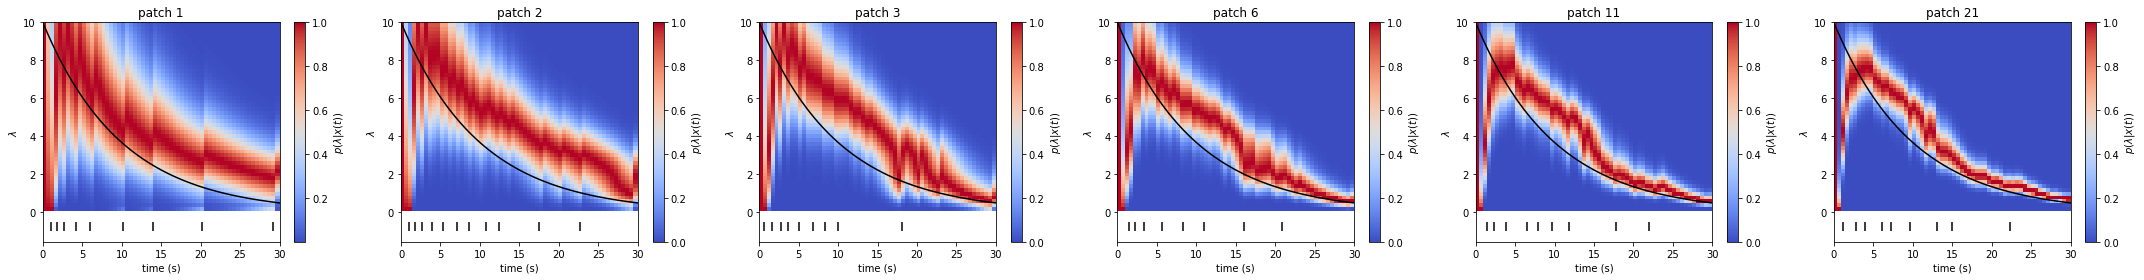

In [662]:
M_plot = [0, 1, 2, 5, 10, 20]
fig, ax = plt.subplots(1, len(M_plot), figsize=(len(M_plot)*5, 4))

cmap = plt.get_cmap('coolwarm')
for i, m in enumerate(M_plot):
    ax_ = ax[i]
    
    # Plot likelihood estimate at sequence m
    im = ax_.pcolormesh(t_bin,
                        lam_range,
                        p[m]/p[m].max(axis=0),
                        cmap=cmap)
    cbar = fig.colorbar(im, ax=ax_)
    cbar.set_label('$p(\lambda | x(t))$')
    
    # Plot true parameter
    ax_.plot(t_bin, 
             lam_0*np.exp(-t_bin/tau), 
             color='black',
             label='true')

    # Plot events of sequence m
    ax_.vlines(t_k[m], 
               ymin=-0.1*ax_.get_ylim()[1],
               ymax=-0.05*ax_.get_ylim()[1],
               color='black',
               label='event')
    
    # Label axis
    ax_.set_title('patch {}'.format(m+1))
    ax_.set_xlabel('time (s)')
    ax_.set_ylabel('$\lambda$')
    
plt.tight_layout()

#### Distribution for $k$th-thinned Poisson process
After we thin events generated by a Poisson process by keeping every $k$th event, what properties does the newly-thinned distribution have? In particular, we want to consider the case where every event has an associated value (i.e. reward volume), and compare the expectation and variance of these values over time.

In [675]:
# Settings for drip process
lam_0 = 10.0 # initial drip parameter
tau = 10.0 # rate of decay of lambda
T = 20.0 # current time in patch
M = 1000 # number of sequences
v_reward = 2.0
v_drip = 0.2
n_drip = int(v_reward/v_drip)

# Create Poisson model
lam = lambda t: lam_0*np.exp(-t/tau) # lambda(t)
Lam = lambda t, s: lam_0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau)) # integral
model = ephys.Poisson(lam=lam, Lam=Lam, homogeneous=False)

# Simulate multiple patches
N_h = np.zeros(M)
N_o = np.zeros(M)
for m in range(M): 
    # Simulate new sequence
    t_k = model.times(interevent=False, s=T)
    N_h[m] = len(t_k)
    N_o[m] = len(t_k[n_drip-1::n_drip]) 
    
print(np.mean(v_drip*N_h), np.var(v_drip*N_h), np.var(v_drip*N_h)/np.mean(v_drip*N_h))
print(np.mean(v_reward*N_o), np.var(v_reward*N_o),  np.var(v_reward*N_o)/np.mean(v_reward*N_o))

17.261599999999998 3.655165440000001 0.2117512536497197
16.354 4.006683999999999 0.2449971872324813


In [676]:
# Settings for fully-observable process
lam_0 *= v_drip/v_reward # initial drip parameter
tau = 10.0 # rate of decay of lambda
T = 20.0 # current time in patch
M = 1000 # number of sequences

# Create Poisson model
lam = lambda t: lam_0*np.exp(-t/tau) # lambda(t)
Lam = lambda t, s: lam_0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau)) # integral
model = ephys.Poisson(lam=lam, Lam=Lam, homogeneous=False)

# Simulate multiple patches
N_h = np.zeros(M)
for m in range(M): 
    # Simulate new sequence
    t_k = model.times(interevent=False, s=T)
    N_h[m] = len(t_k)
    
print(np.mean(v_reward*N_h), np.var(v_reward*N_h), np.var(v_reward*N_h)/np.mean(v_reward*N_h))

17.456 33.904064 1.9422584784601282


### Marginal value theorem and optimal behavioral strategies
Given the non-homogeneous Poisson process that generates rewards in patches, how should an animal behave optimally in the environment to maximize reward? Because the expectation of the Poisson drip process is analogous to the deterministic filling process, we can simply solve for the optimal time as before, using the relation $V_{drip} \lambda_0 = r_0$ (see the `poisson_drip` notebook for details). While the answer is obvious in the deterministic version, one question that remains for this stochastic process is the optimal behavior strategy. Should it still be based on a strict leaving time, or does leaving after rewards near the leaving time lead to larger harvest rates? Because non-homogeneous Poisson processes still retain the memoryless property, I believe that for a fully-observable process, the time threshold is still optimal. However, if the rewards are given incrementally (e.g. every 10 events), then perhaps leaving after a reward near the time is a better strategy. Let's simulate some scenarios to find out.

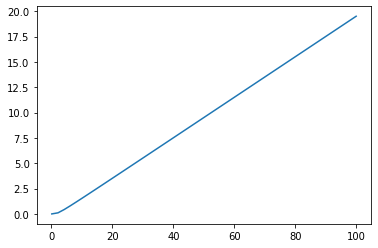

In [808]:
x = np.linspace(0.1, 100.0)
f = lambda x: 1.0/(np.exp(5/x) - 1)
plt.plot(x, f(x))